# Introduction
In this notebook we will extract patterns formed between observed and latent variables as learnt from a deep generative model, specifically a variational autoencoder (VAE). Log-linear models are step-wise fit to discretized synthetic data sampled from the VAE. The corresponding ```PatternExtractor```([https://github.com/ssehztirom/patternextractor.jl](https://github.com/ssehztirom/patternextractor.jl) method is demonstrated on single cell RNA-Seq data from [Tasic et al. 2016](https://www.nature.com/articles/nn.4216) you already got acquainted with in the morning session. Further details can be found in [Hess et al. 2020](https://academic.oup.com/bioinformatics/article/36/20/5045/5869514). 

We will start with a VAE for Bernoulli distributed data. To that end, we will discretize the scRNA-Seq data. Later, we will employ an scVAE such as introduced in [Lopez et al. 2018](https://www.nature.com/articles/s41592-018-0229-2).

In this tutorial you will get to know different methods to draw from the joint distribution learnt by the  VAE, specifically by drawing from the prior distribution and the posterior distribution. 

You will also learn about the hyperparameters of the ```PatternExtractor```.

# Loading and installing necessary packages

In [1]:
using Pkg; 
cd(@__DIR__)
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/GitHub/GCB-2022-WS1`


In [2]:
Pkg.upgrade_manifest()
Pkg.resolve()

LoadError: Format of manifest file at `/Users/moritz/GitHub/GCB-2022-WS1/Manifest.toml` already up to date: manifest_format == 2.0.0

In [3]:
using Pkg
Pkg.add(["Clustering","Seaborn","PyPlot","UMAP","LinearAlgebra","Distances","Distributions","Random","Flux","Zygote","SpecialFunctions","StatsBase","Statistics","DelimitedFiles"])
Pkg.add(url="https://github.com/ssehztirom/LogLinearModels.jl")
Pkg.add(url="https://github.com/ssehztirom/patternextractor.jl")
Pkg.add(url="https://github.com/maren-ha/scVI.jl")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/GitHub/GCB-2022-WS1/Project.toml`
  No Changes to `~/GitHub/GCB-2022-WS1/Manifest.toml`
    Updating git-repo `https://github.com/ssehztirom/LogLinearModels.jl`
   Resolving package versions...
  No Changes to `~/GitHub/GCB-2022-WS1/Project.toml`
  No Changes to `~/GitHub/GCB-2022-WS1/Manifest.toml`
    Updating git-repo `https://github.com/ssehztirom/patternextractor.jl`
   Resolving package versions...
  No Changes to `~/GitHub/GCB-2022-WS1/Project.toml`
  No Changes to `~/GitHub/GCB-2022-WS1/Manifest.toml`
    Updating git-repo `https://github.com/maren-ha/scVI.jl`
   Resolving package versions...
  No Changes to `~/GitHub/GCB-2022-WS1/Project.toml`
  No Changes to `~/GitHub/GCB-2022-WS1/Manifest.toml`


In [4]:
using PyPlot
using UMAP
using LinearAlgebra
using Distributions
using Random
using Flux
using Zygote
using SpecialFunctions
using LogLinearModels
using PatternExtractor
using StatsBase
using Statistics
using DelimitedFiles
using Distances
using Clustering
using Seaborn
using scVI 

# Some helper functions

In [5]:
# Standardize gene expression data.
function zscores(x)
    (x .- mean(x, dims = 1)) ./ std(x, dims = 1)
end

# Principal component analysis (PCA)
function prcomps(mat, standardizeinput = true)
    if standardizeinput
        mat = zscores(mat)
    end
    u,s,v = svd(mat)
    prcomps = u * Diagonal(s)
    return prcomps
end

# hierarchically clusters gene expression matrix, function returns distances of rows, columns, 
# ordering of rows, ordering of columns and the reordered matrix
function cluster_matrix(mat;clustern=true,clusterp=true)
    ndist = pairwise(Distances.Euclidean(),mat,dims=1)
    pdist = pairwise(Distances.Euclidean(),mat,dims=2)
    norder = hclust(ndist,:complete).order
    porder = hclust(pdist,:complete).order
    if clustern
        mat = mat[norder,:]
    end
    if clusterp
        mat = mat[:,porder]
    end
    return ndist,pdist,norder,porder,mat
end

# Function to dichotomize data at "selquantile"
function dichotomize(x;selquantile=0.5)
	n,p=size(x)
	dicho = zeros(n,p)
	for i=1:p
		dicho[:,i] = ifelse.(x[:,i] .>quantile(x[:,i],selquantile),1.0,0.0)
	end
	return dicho
end

# function for reformatting samples from a VAE, data is just restructured, no magic happening here.
function reformatsamples(samples)
    zs = fill(0.0,length(samples),length(samples[1][1]))
    xs = fill(0.0,length(samples),length(samples[1][2]))
    for i = 1:length(samples)
        zs[i,:] = samples[i][1]
        xs[i,:] = samples[i][2]
    end
    return zs,xs
end



reformatsamples (generic function with 1 method)

# Code for training VAEs

In [6]:
# a struct defining a variational autoencoder
struct VAE
	encoder
	mu
	logsigma
	decoder
end

# cross entropy between reconstruction and observed data
function logp_x_z(xhat,x)
	ce(x,y) =  y * log(x + eps()) + (1 - y) * log(1 - x + eps())
	return sum(ce.(xhat,x))
end

# Sampling from a Gaussian distribution with expectation mu and standard deviation exp(logsigma)
function latentz(mu,logsigma)
	return mu  + exp(logsigma) * randn()
end


# Kullback Leibler divergence between posterior distribution and Gaussian distribution
function kl_q_p(mu,logsigma)
	return 0.5 * sum(exp.(2 .* logsigma) + mu.^2 .- 1 .- 2 .* logsigma)
end

# get values for the parameters of the posterior distribution
g(x) = (h = vae.encoder(x); (vae.mu(h), vae.logsigma(h)))	

# Combined loss function
loss(x) = ((mu,logsigma) = g(x);
    (sum(logp_x_z(vae.decoder(latentz.(mu,logsigma)),x))
        - Beta * kl_q_p(mu,logsigma)) / batchsize)


loss (generic function with 1 method)

Here we specify functions for sampling from the prior or the posterior distribution.

In [7]:
function posteriorsample(x) 
    mu,logsigma = g(x)
    zs = latentz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

function priorsample(x) 
    mu,logsigma = g(x)
    mu = zeros(length(mu))
    logsigma = zeros(length(logsigma))
    zs = latentz.(mu, logsigma)
    muz = vae.decoder(zs)
    return zs, muz
end

priorsample (generic function with 1 method)

> **Exercise:** 
>
> How is sampling from the prior or posterior distribution achieved (when inspecting the above declared function) ?

# The ```PatternExtractor``` approach ...
learns the connection between latent variables ```z``` or ```u```, learnt from a deep generative approach and the observed variables ```x```.


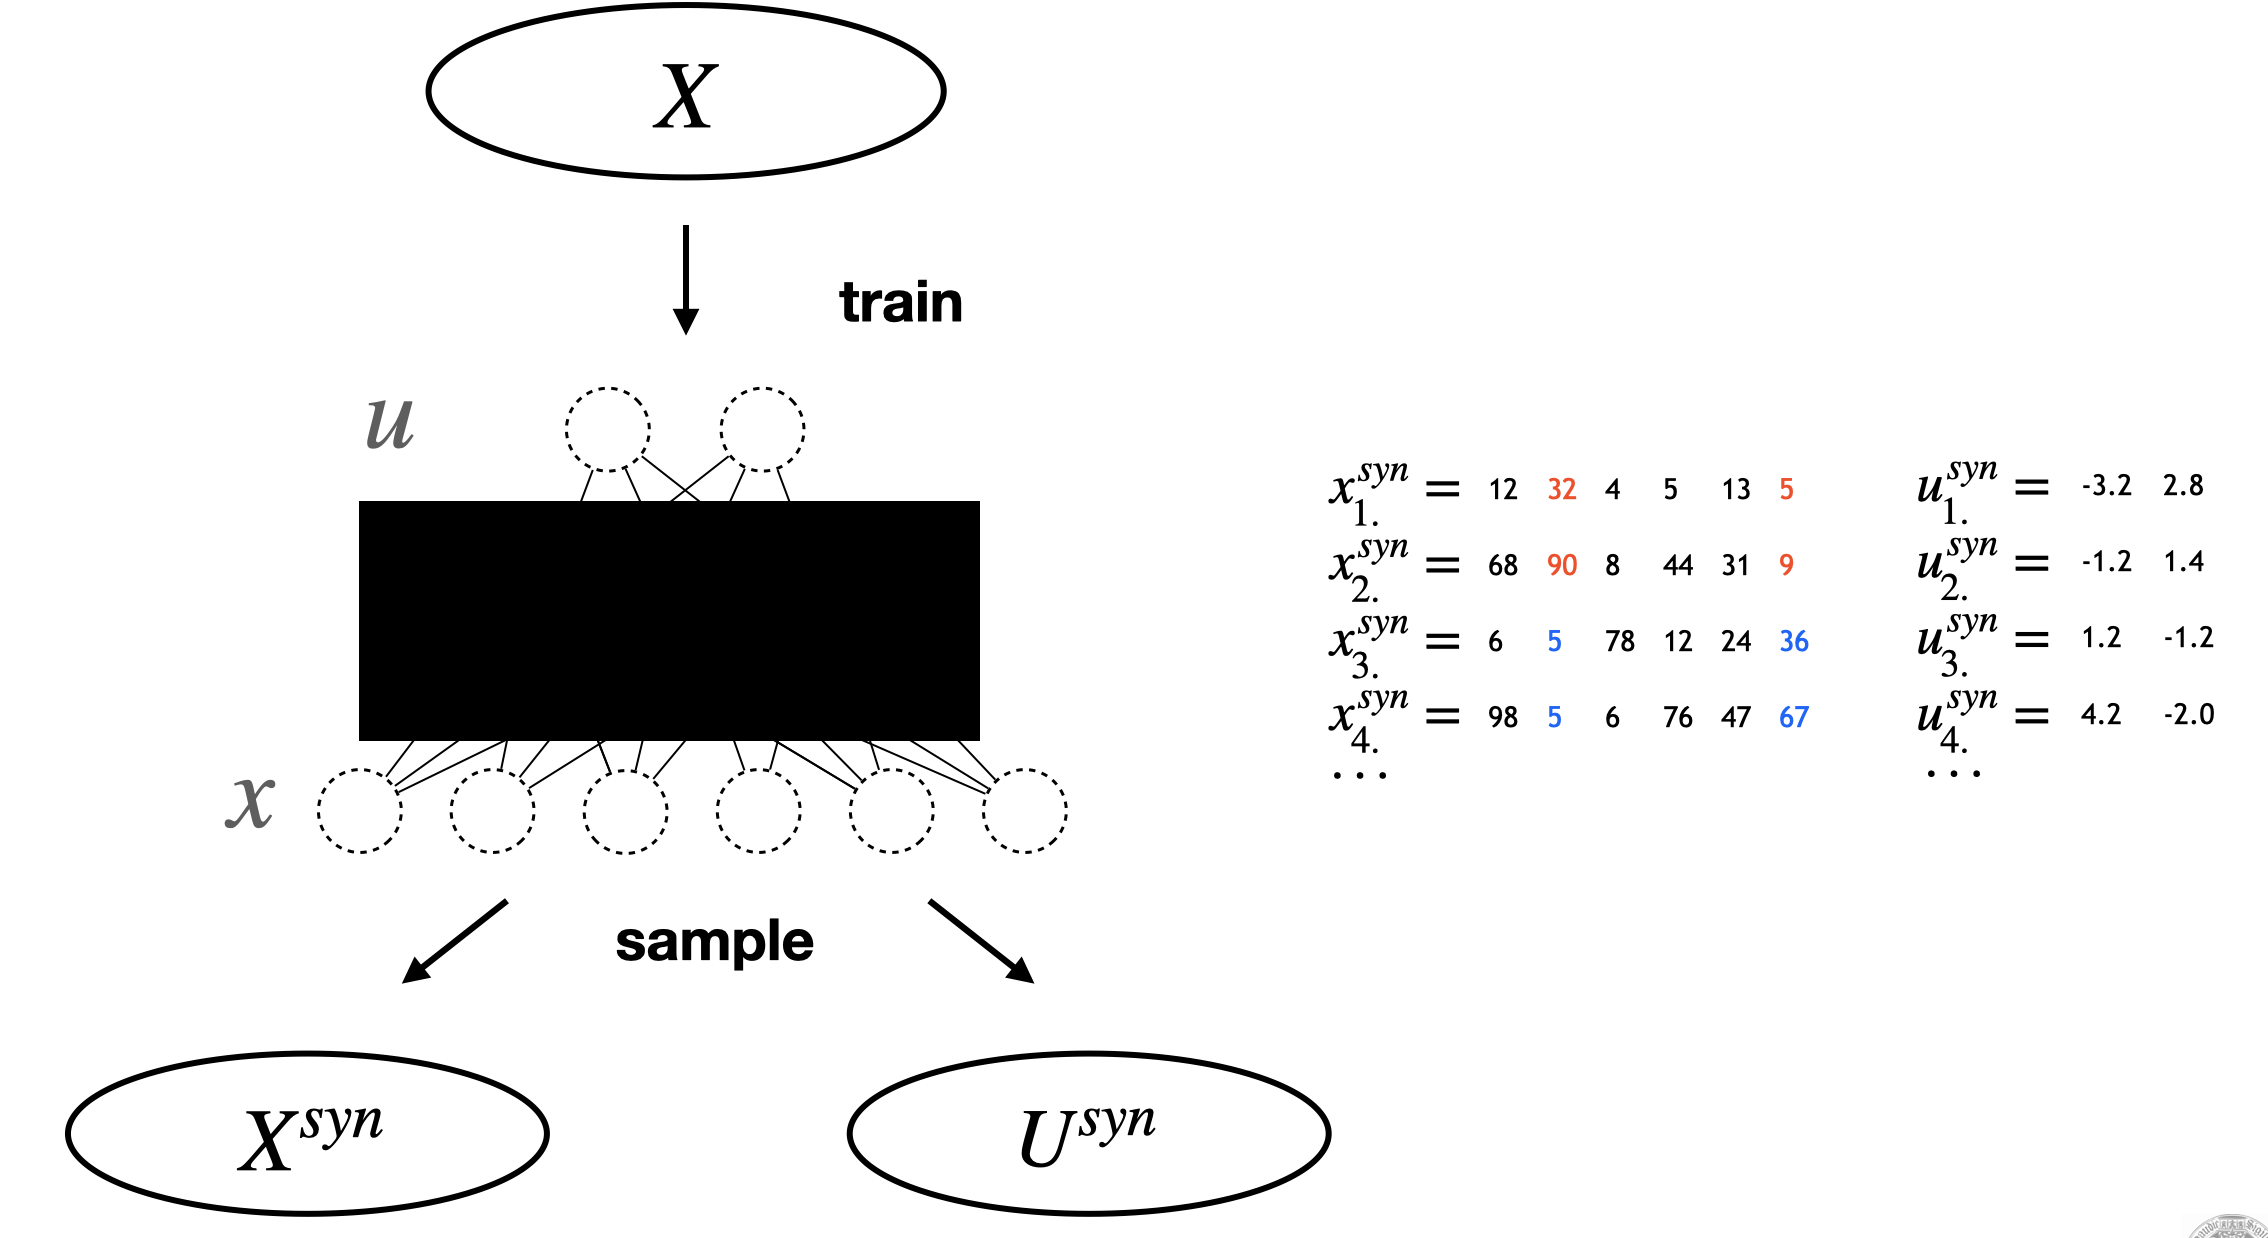
Figure 1

## Starting with a VAE with Bernoulli distributed observed variables

Loading Tasic et al. Data gene expression matrix

In [8]:
x = readdlm("data/single_cell_mat.txt",'\t')'

1525×180 adjoint(::Matrix{Float64}) with eltype Float64:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                       

We inspect the distribution of a random selection of genes.

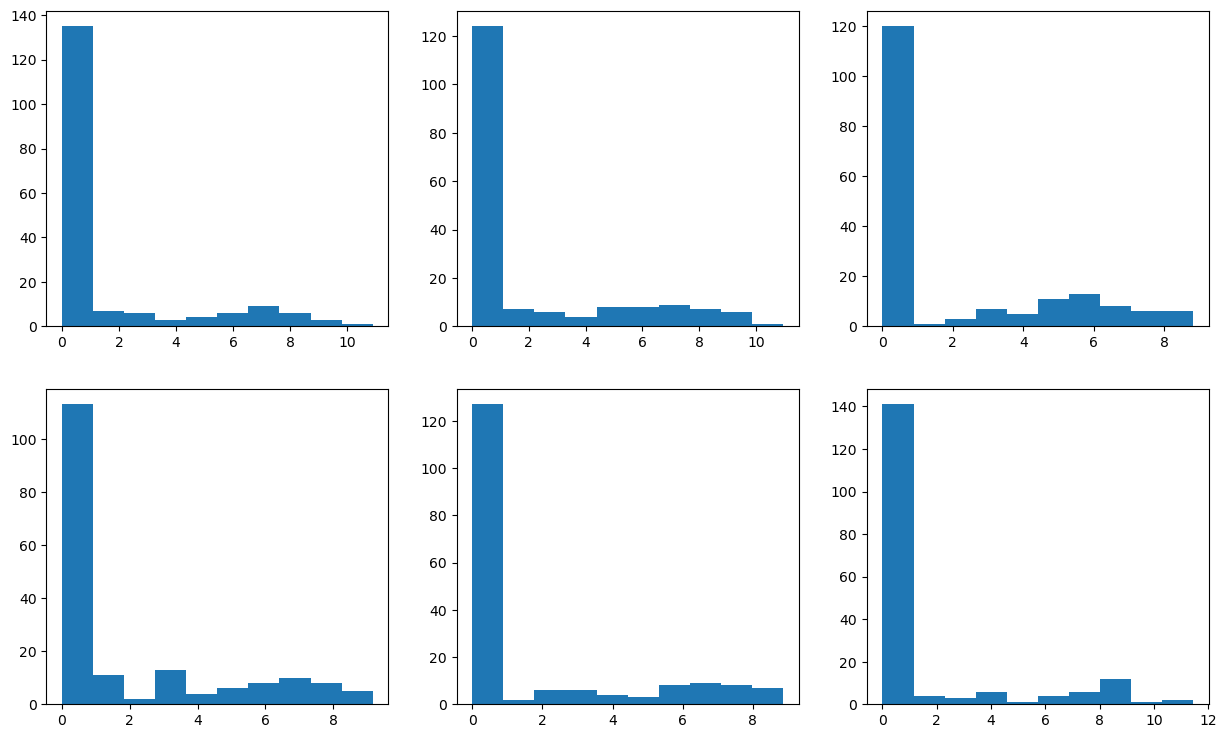

([141.0, 4.0, 3.0, 6.0, 1.0, 4.0, 6.0, 12.0, 1.0, 2.0], [0.0, 1.1445869201476588, 2.2891738402953177, 3.4337607604429765, 4.578347680590635, 5.722934600738294, 6.867521520885953, 8.012108441033611, 9.15669536118127, 10.30128228132893, 11.445869201476588], (PyObject <matplotlib.patches.Rectangle object at 0x17d1cac40>, PyObject <matplotlib.patches.Rectangle object at 0x17d168070>, PyObject <matplotlib.patches.Rectangle object at 0x17d1da250>, PyObject <matplotlib.patches.Rectangle object at 0x17d1da460>, PyObject <matplotlib.patches.Rectangle object at 0x17d1da670>, PyObject <matplotlib.patches.Rectangle object at 0x17d1da880>, PyObject <matplotlib.patches.Rectangle object at 0x17d1daa90>, PyObject <matplotlib.patches.Rectangle object at 0x17d1daca0>, PyObject <matplotlib.patches.Rectangle object at 0x17d1daeb0>, PyObject <matplotlib.patches.Rectangle object at 0x17d1ea040>))

In [9]:
figure()
fig, ax = subplots(nrows=2, ncols=3, figsize=(15, 9))
ax[1].hist(log.(x[20,:].+1),10)
ax[2].hist(log.(x[10,:].+1),10)
ax[3].hist(log.(x[4,:].+1),10)
ax[4].hist(log.(x[100,:].+1),10)
ax[5].hist(log.(x[80,:].+1),10)
ax[6].hist(log.(x[50,:].+1),10)

We then load cell type labels (```y```)  and genenames

In [10]:
y = readdlm("data/celltype.txt")[:,1]

1525-element Vector{Any}:
 "Vip"
 "Vip"
 "L4"
 "Vip"
 "Vip"
 "L2/3"
 "L2"
 "L2/3"
 "L4"
 "L2"
 "Pvalb"
 "L2/3"
 "Vip"
 ⋮
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Pvalb"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"

In [11]:
genenames = readdlm("data/genes.txt")[:,1]

180-element Vector{Any}:
 "Adora1"
 "Adra1a"
 "Adra1b"
 "Adra1d"
 "Adra2a"
 "Adrb1"
 "Adrb2"
 "Aqp4"
 "Arf5"
 "Batf3"
 "Bcl6"
 "Bgn"
 "Brca1"
 ⋮
 "Tcerg1l"
 "Tcf7l2"
 "Th"
 "Tnfaip8l3"
 "Tnmd"
 "Tpbg"
 "Tph2"
 "Ucma"
 "Vip"
 "Vtn"
 "Wt1"
 "Xdh"

The ```PatternExtractor``` identifies interactions between observed and latent variables by fitting log-linear models to a cross table of increasing dimensionality. We could either learn the joint distribution of observed and latent variables in an untransformed way as described in Figure 1 (what we will do in the second part of the tutorial). When we then draw samples from the learnt joint distribution, we have to dichotomize / categorize the data in order to be able to build the cross table we want to model. Here, we will start with a VAE for binary data (Bernoulli distributed) so we discretize the training data before training the VAE.

We dichotomize the data, as our VAE is for Bernoulli distributed data.

We set the quantile at which we dichotomize the data.

In [12]:
dichoquantile = 0.8

0.8

> **Exercise:** 
>
> How does ```dichoquantile``` affects the extraction of patterns and why? Based on which information would you set ```dichoquantile``` ?

In [13]:
x01 = dichotomize(x, selquantile=dichoquantile)

1525×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

We establish test and training datasets.

In [14]:
n,p = size(x01)
randindex = Random.randperm(n);
trainidx = randindex[1:Int(round(.632*n))];
testidx = randindex[Int(round(.632*n))+1:n];
testdata = [x01[i,:]' for i in Iterators.partition(testidx,1)]; 
evalvae() = (push!(losslist,sum(lossplus.(testdata[1:10],testys[1:10]))))#;println(sum(x->sum(x.^2),Flux.params(vae.decoder))))

evalvae (generic function with 1 method)

We then train a VAE on the discretized data.

In [15]:
Random.seed!(1234)
Dh = 50
Dh2 = 10
Dz = 5
epochs = 500
learningrate = 0.004
batchsize=10
Beta =1

1

We initialize a VAE

In [16]:
Random.seed!(1234)
vae =  VAE(Flux.Chain(Flux.Dense(p,Dh,tanh)),#,Flux.Dense(Dh,Dh2,tanh)),
    Flux.Dense(Dh,Dz),
    Flux.Dense(Dh,Dz),
    Flux.Chain(Flux.Dense(Dz,Dh,relu),Flux.Dense(Dh,p,sigmoid)))

VAE(Chain(Dense(180 => 50, tanh)), Dense(50 => 5), Dense(50 => 5), Chain(Dense(5 => 50, relu), Dense(50 => 180, σ)))

... and train it on the training data.

In [17]:
optimizer = ADAM(learningrate)
vaeparams = Flux.params(vae.encoder,vae.mu,vae.logsigma,vae.decoder)
losslist = []

for i = 1:25
    traindata = [x01[i,:]' for i in Iterators.partition(trainidx, batchsize)][1:(end-1)]
    idx = 0
    for x = traindata 
        idx += 1
            batch_loss, back = Flux.pullback(vaeparams) do
            -loss(x)
            end
            push!(losslist,batch_loss)
            grad = back(1f0)
            Flux.Optimise.update!(optimizer, vaeparams, grad)
    end
end

We draw synthetic observations from the prior distribution. Specifically we sample 5 times the number of test observations resulting in a total of 2805 observations.

In [18]:
xfactor = 10

10

In [19]:
vaesamples = priorsample.(vcat([testdata for i = 1:xfactor]...))

5610-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([-0.06654336481317988, 1.7166716989297064, 1.3636498254718366, -1.618602589423574, 2.317981336452398], [8.014895046780237e-5, 0.07143854383941912, 0.4996586596945515, 0.006377432345187025, 0.021601292797796434, 0.01171041522208238, 0.00026853092429069775, 0.21078521213690368, 0.025768441591923538, 1.0728730679765031e-5  …  0.018151055894544167, 0.07401250076318336, 0.00013071746666496045, 0.10661798051552925, 0.06481007189618629, 1.2193306597548548e-7, 0.4435100927084367, 3.2731335347265516e-5, 4.844901240696644e-5, 0.0024633062698200133])
 ([1.0998261362480137, -0.10118398286197415, -1.362263502781482, -1.455531550136396, 0.6639585942369991], [0.011739430582336148, 0.43054354441477277, 0.1954123628691785, 0.051121655374710036, 0.007069201700151358, 0.1174818965201635, 0.0004411272658828983, 0.30471275847851753, 0.09689747347782561, 0.0005819219728474495  …  0.004458167502303418, 0.07639404382725203, 0.0007196471390422775,

Just some reformatting.

In [20]:
zs,xs = reformatsamples(vaesamples)

([-0.06654336481317988 1.7166716989297064 … -1.618602589423574 2.317981336452398; 1.0998261362480137 -0.10118398286197415 … -1.455531550136396 0.6639585942369991; … ; -1.815463881532019 0.6578995716530056 … 1.2733512466784278 -1.7652564036730676; 0.45123446527006894 -0.6782850080039663 … -1.4960198380937841 1.8095557671157179], [8.014895046780237e-5 0.07143854383941912 … 4.844901240696644e-5 0.0024633062698200133; 0.011739430582336148 0.43054354441477277 … 0.005220856024607034 0.018166309222462786; … ; 0.4789057337914402 0.03010472056196878 … 0.0038496727501910926 0.002330720621407547; 0.015170928929160284 0.21422161181190943 … 0.0005119125915125504 0.017240991904755226])

We inspect the covariance of samples from the latent variables.

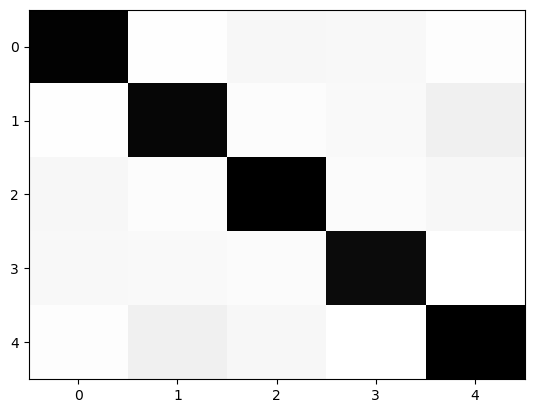

PyObject <matplotlib.image.AxesImage object at 0x17da73850>

In [21]:
PyPlot.figure()
PyPlot.imshow(cov(zs),aspect="auto",cmap="binary")

We dichotomize the data.

In [22]:
zsbin = ifelse.(zs.>0,1,0)
xsbin = float.(xs .> rand(size(xs)...))

5610×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.

We set the only hyperparameter of the method, namely the number of genes which we want to select.

> **Exercises:** 
>
> What might be a meaningful number for nvars ? 
>
> How many samples from the VAE are needed ? (hint-> ```xvar```)

In [23]:
nvars = 8

8

## Select variables
We then fit log-linear models in an iterative manner. The provided convenience function returns the G squared statistics for each selected variable during the step-wise model fit, the g squared statistics for all observed and latent variables and the indices of the selected variables.

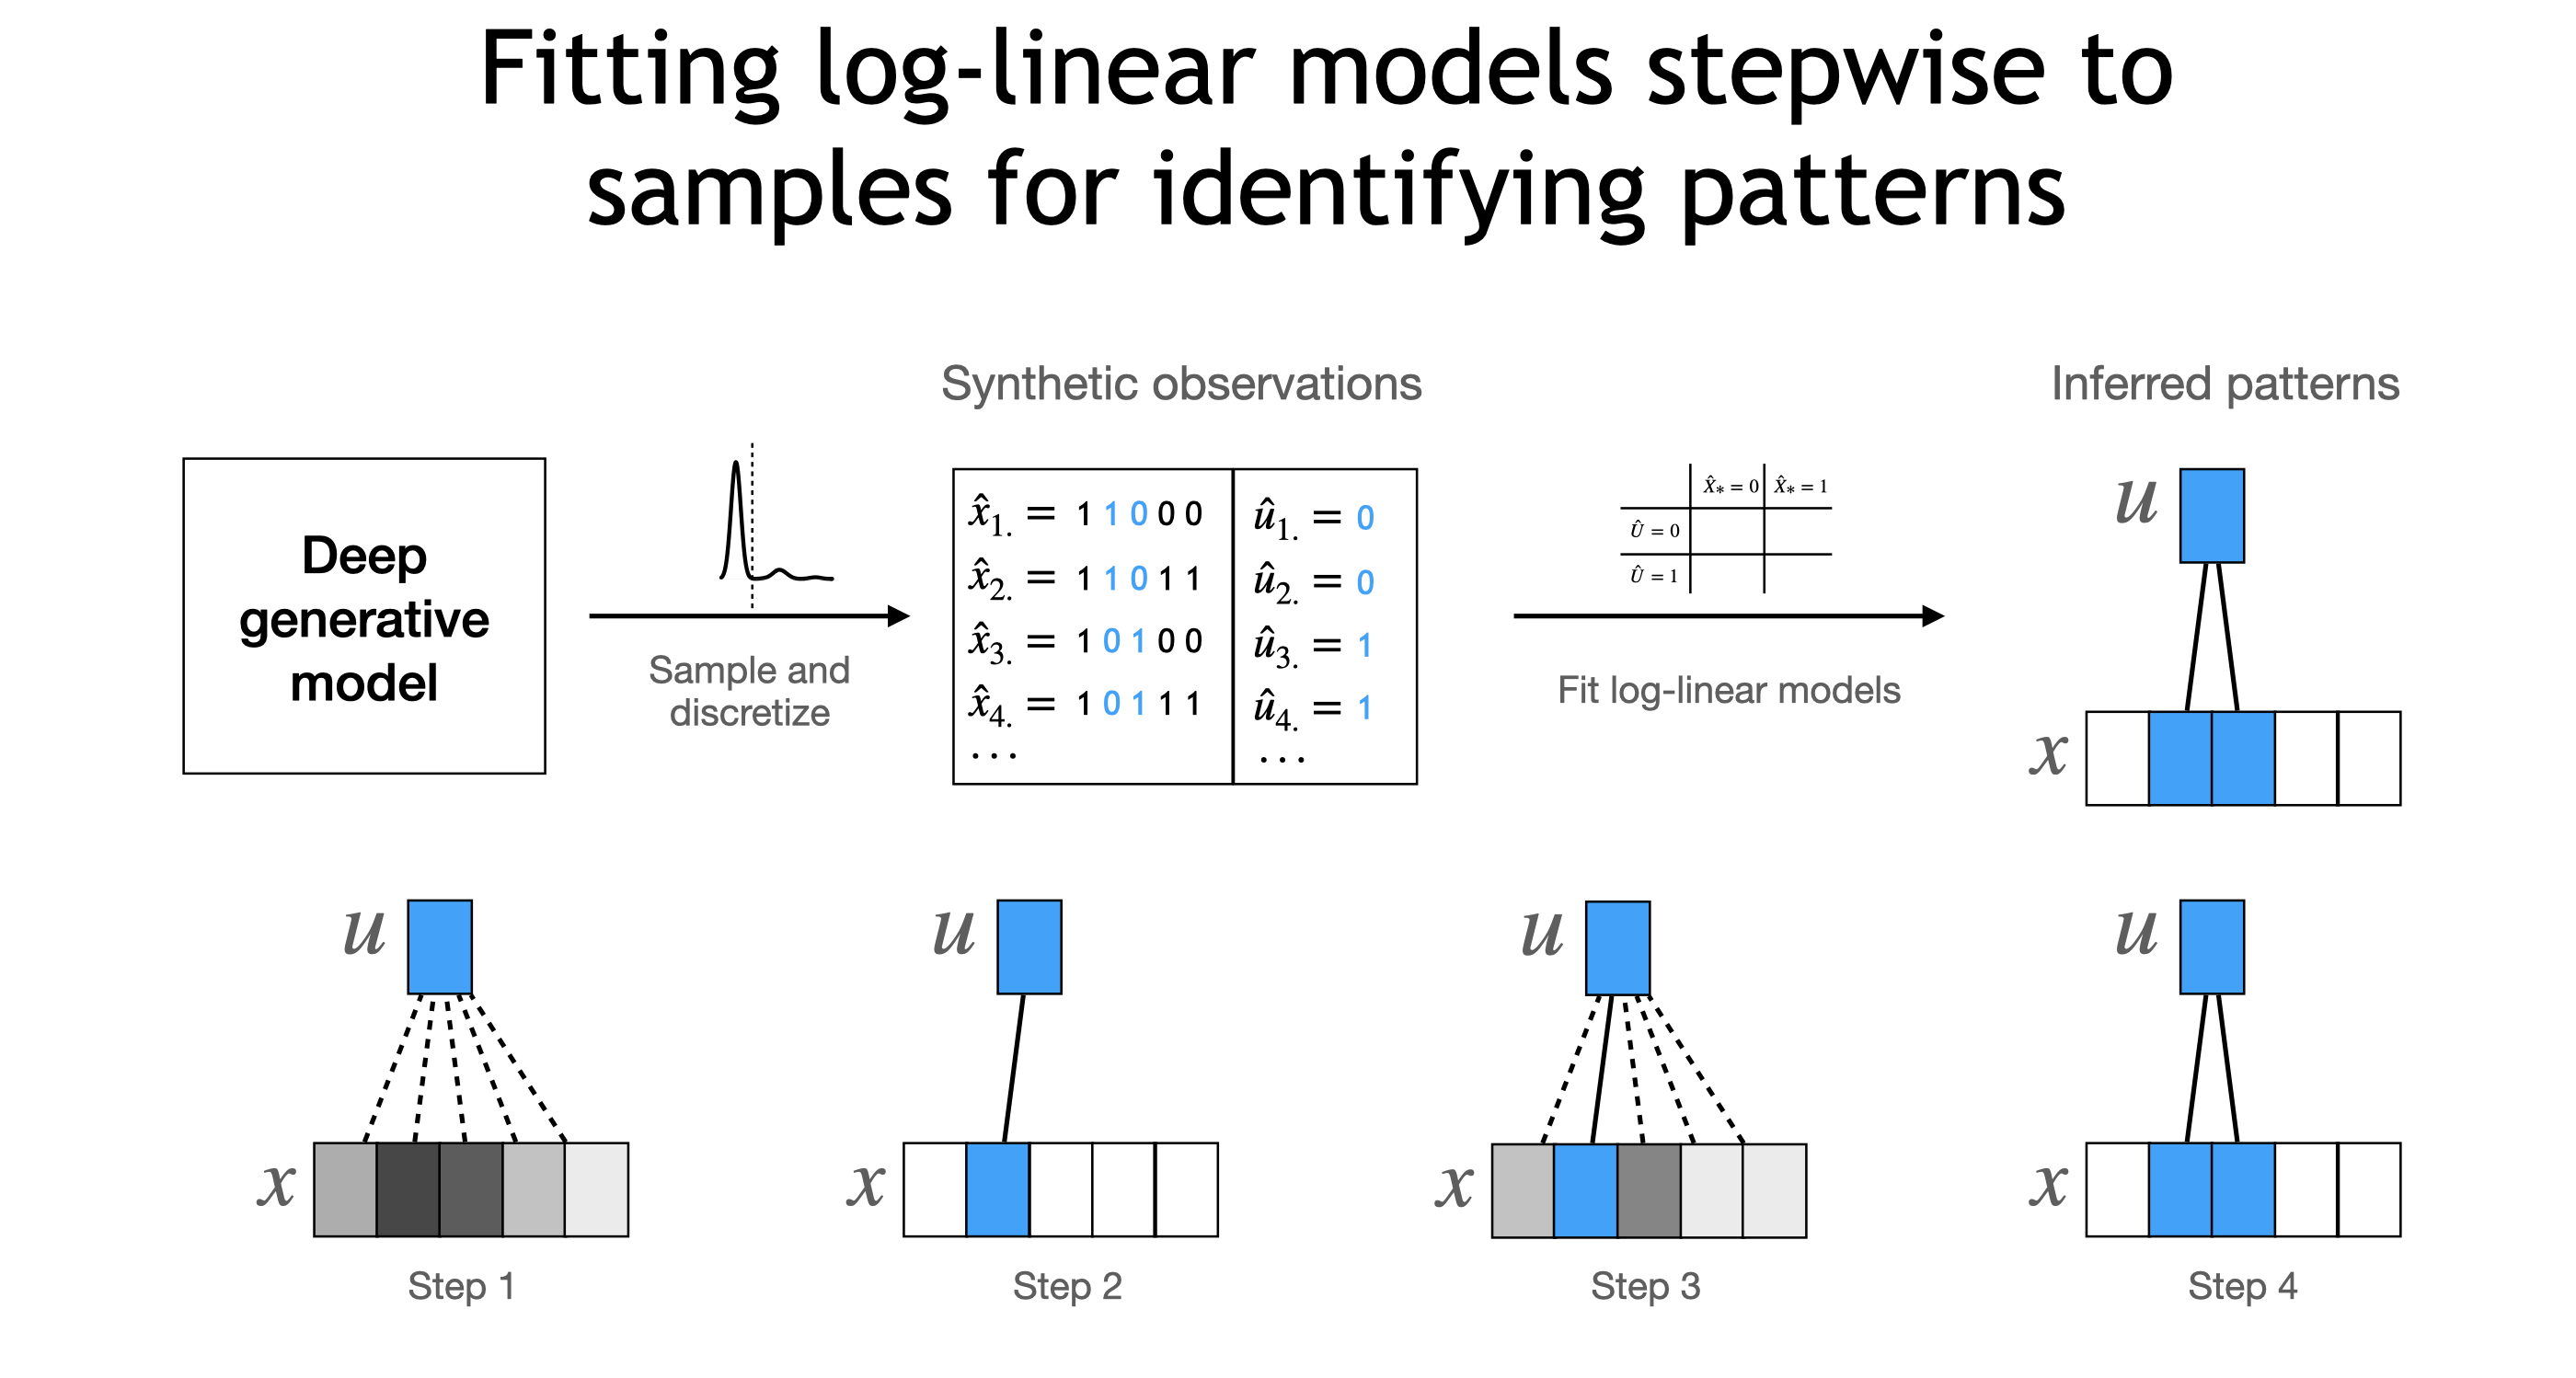
Figure 2

In [24]:
res = extract_pattern(nvars,xsbin,zsbin)

([1547.3841591316157, 998.596761739557, 638.0940138828436, 576.5578550324161, 543.5346011397965, 532.251309384663, 481.5071437941496, 456.13164797147715], [150, 155, 163, 48, 51, 143, 17, 39], Any[[7.091348741704394 250.1098437173407 … 436.80004827371204 13.121924515192887; 15.805255920341637 53.714293719741875 … 429.69756333627714 136.1980744871559; … ; 0.6355153273093936 4.295022976533534 … 69.21478178452332 98.78933875158886; 1.964538948735381 7.147424555444896 … 0.02247674984271142 0.7360658742238524], [13.373896422678852 341.67180331378 … 300.8924215588939 37.87293339522539; 27.300354210717323 151.5537591752095 … 228.8013648494655 93.38589304885447; … ; 4.181843333943135 0.06470565090937641 … 19.475011639028867 77.89227881503022; 1.9632163496716557 7.560125833396534 … 2.047396280012851 4.767478023358391], [10.21685214671936 272.87803145011196 … 222.78993481561767 17.972209800234197; 32.285193759154595 118.36765015774522 … 176.04930453286715 130.27817119208225; … ; 6.16700030791959

We inspect the g squared statistics for the selected ```nvars``` variables.

In [25]:
res[1]

8-element Vector{Float64}:
 1547.3841591316157
  998.596761739557
  638.0940138828436
  576.5578550324161
  543.5346011397965
  532.251309384663
  481.5071437941496
  456.13164797147715

In [26]:
genenames[res[2]]

8-element Vector{Any}:
 "Pvalb"
 "Rorb"
 "Sst"
 "Cxcl14"
 "Drd1a"
 "Parm1"
 "Car4"
 "Col6a1"

## Inspect the G-Squared matrix for each selected variable
The Matrices indicate the G-Squared statistic used for selecting a variable at a given iteration (here ```nvars``` iterations evaluated).
In the below stated example, g-squared matrices for iteration 1-nvars (based on which the 1st to ```nvars```th variable are selected) are shown. In the first plot, we only inspect statistics for the finally selected variables, while in the second plot, we investigate a clustered view (only genes are clustered) on all genes and latent variables.

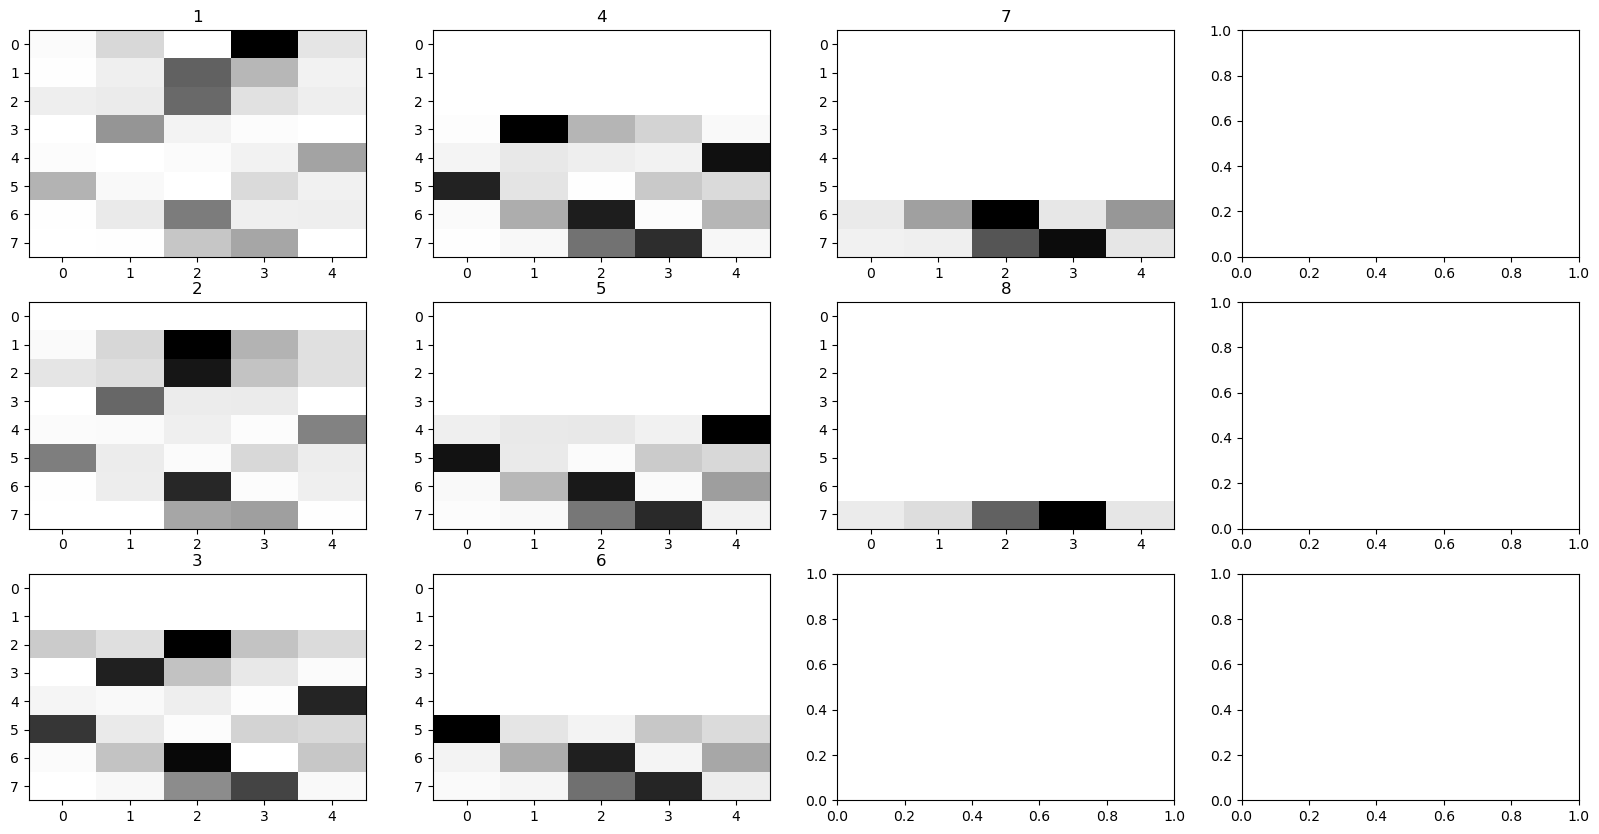

In [27]:
PyPlot.figure()
fig, ax = subplots(nrows=3, ncols=4, figsize=(20, 10))
for i = 1:length(res[2])
    
    ax[i].imshow(res[3][i][res[2],:],aspect="auto",cmap="binary")
    ax[i].set_title(string(i))
end
# ax = PyPlot.imshow(res[3][1][res[2],:],aspect="auto",cmap="binary")

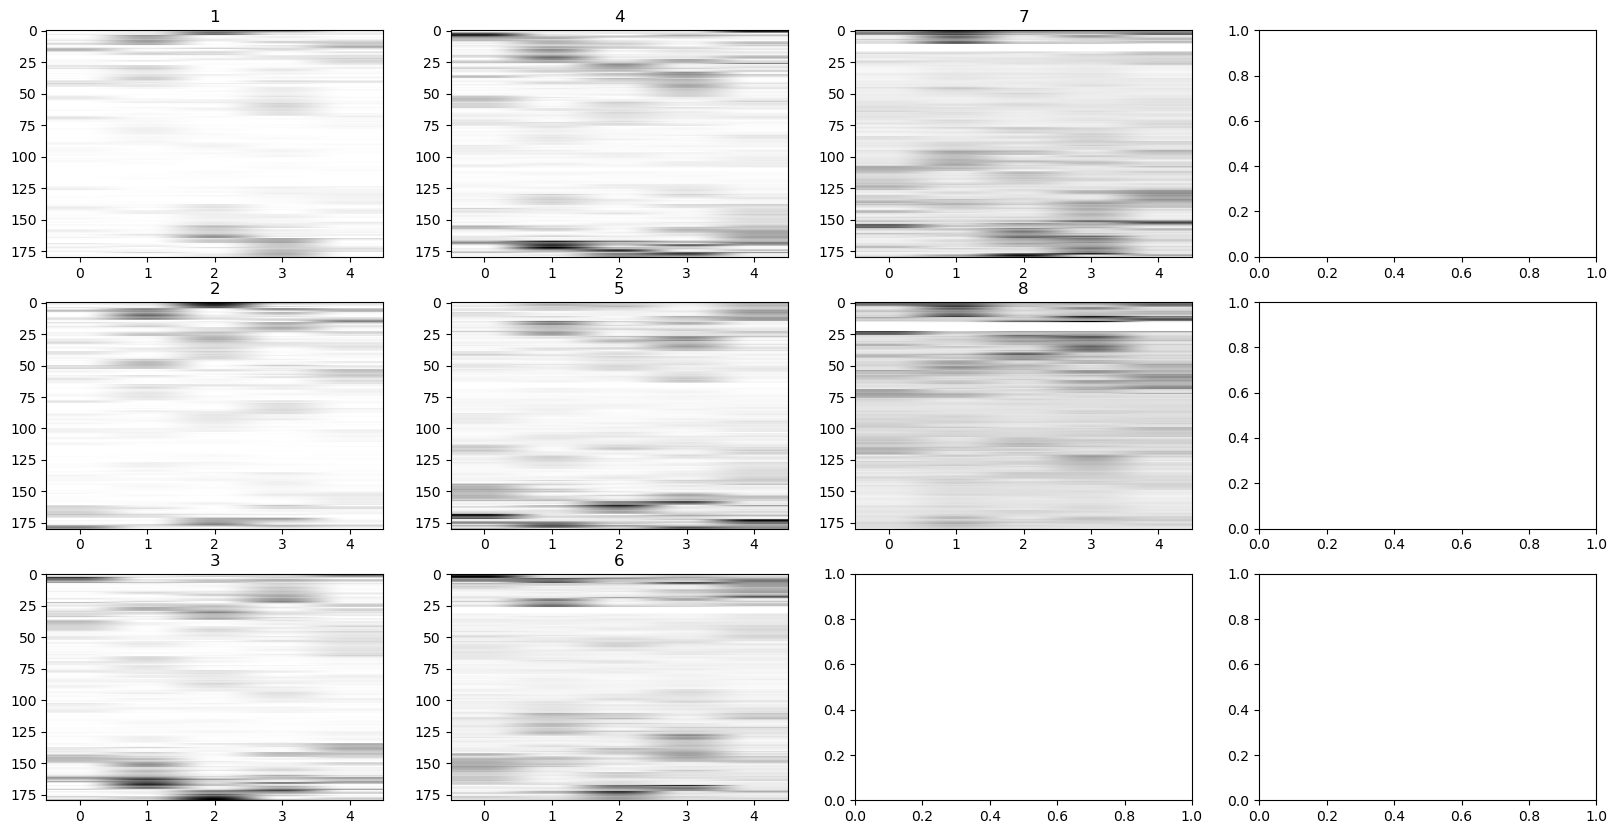

In [28]:
PyPlot.figure()
fig, ax = subplots(nrows=3, ncols=4, figsize=(20, 10))
for i = 1:length(res[2])
    ax[i].imshow(cluster_matrix(res[3][i],clusterp=false)[5],aspect="auto",cmap="binary")
    ax[i].set_title(string(i))
end


> **Question:** 
>
> What do the columns relate to ?
> What do you overall observe in the plots ?

## Annotate synthetic observations

Based on patterns in the selected ```nvars``` variables, we then assign a real expression vector to the samples drawn from the prior distribution.

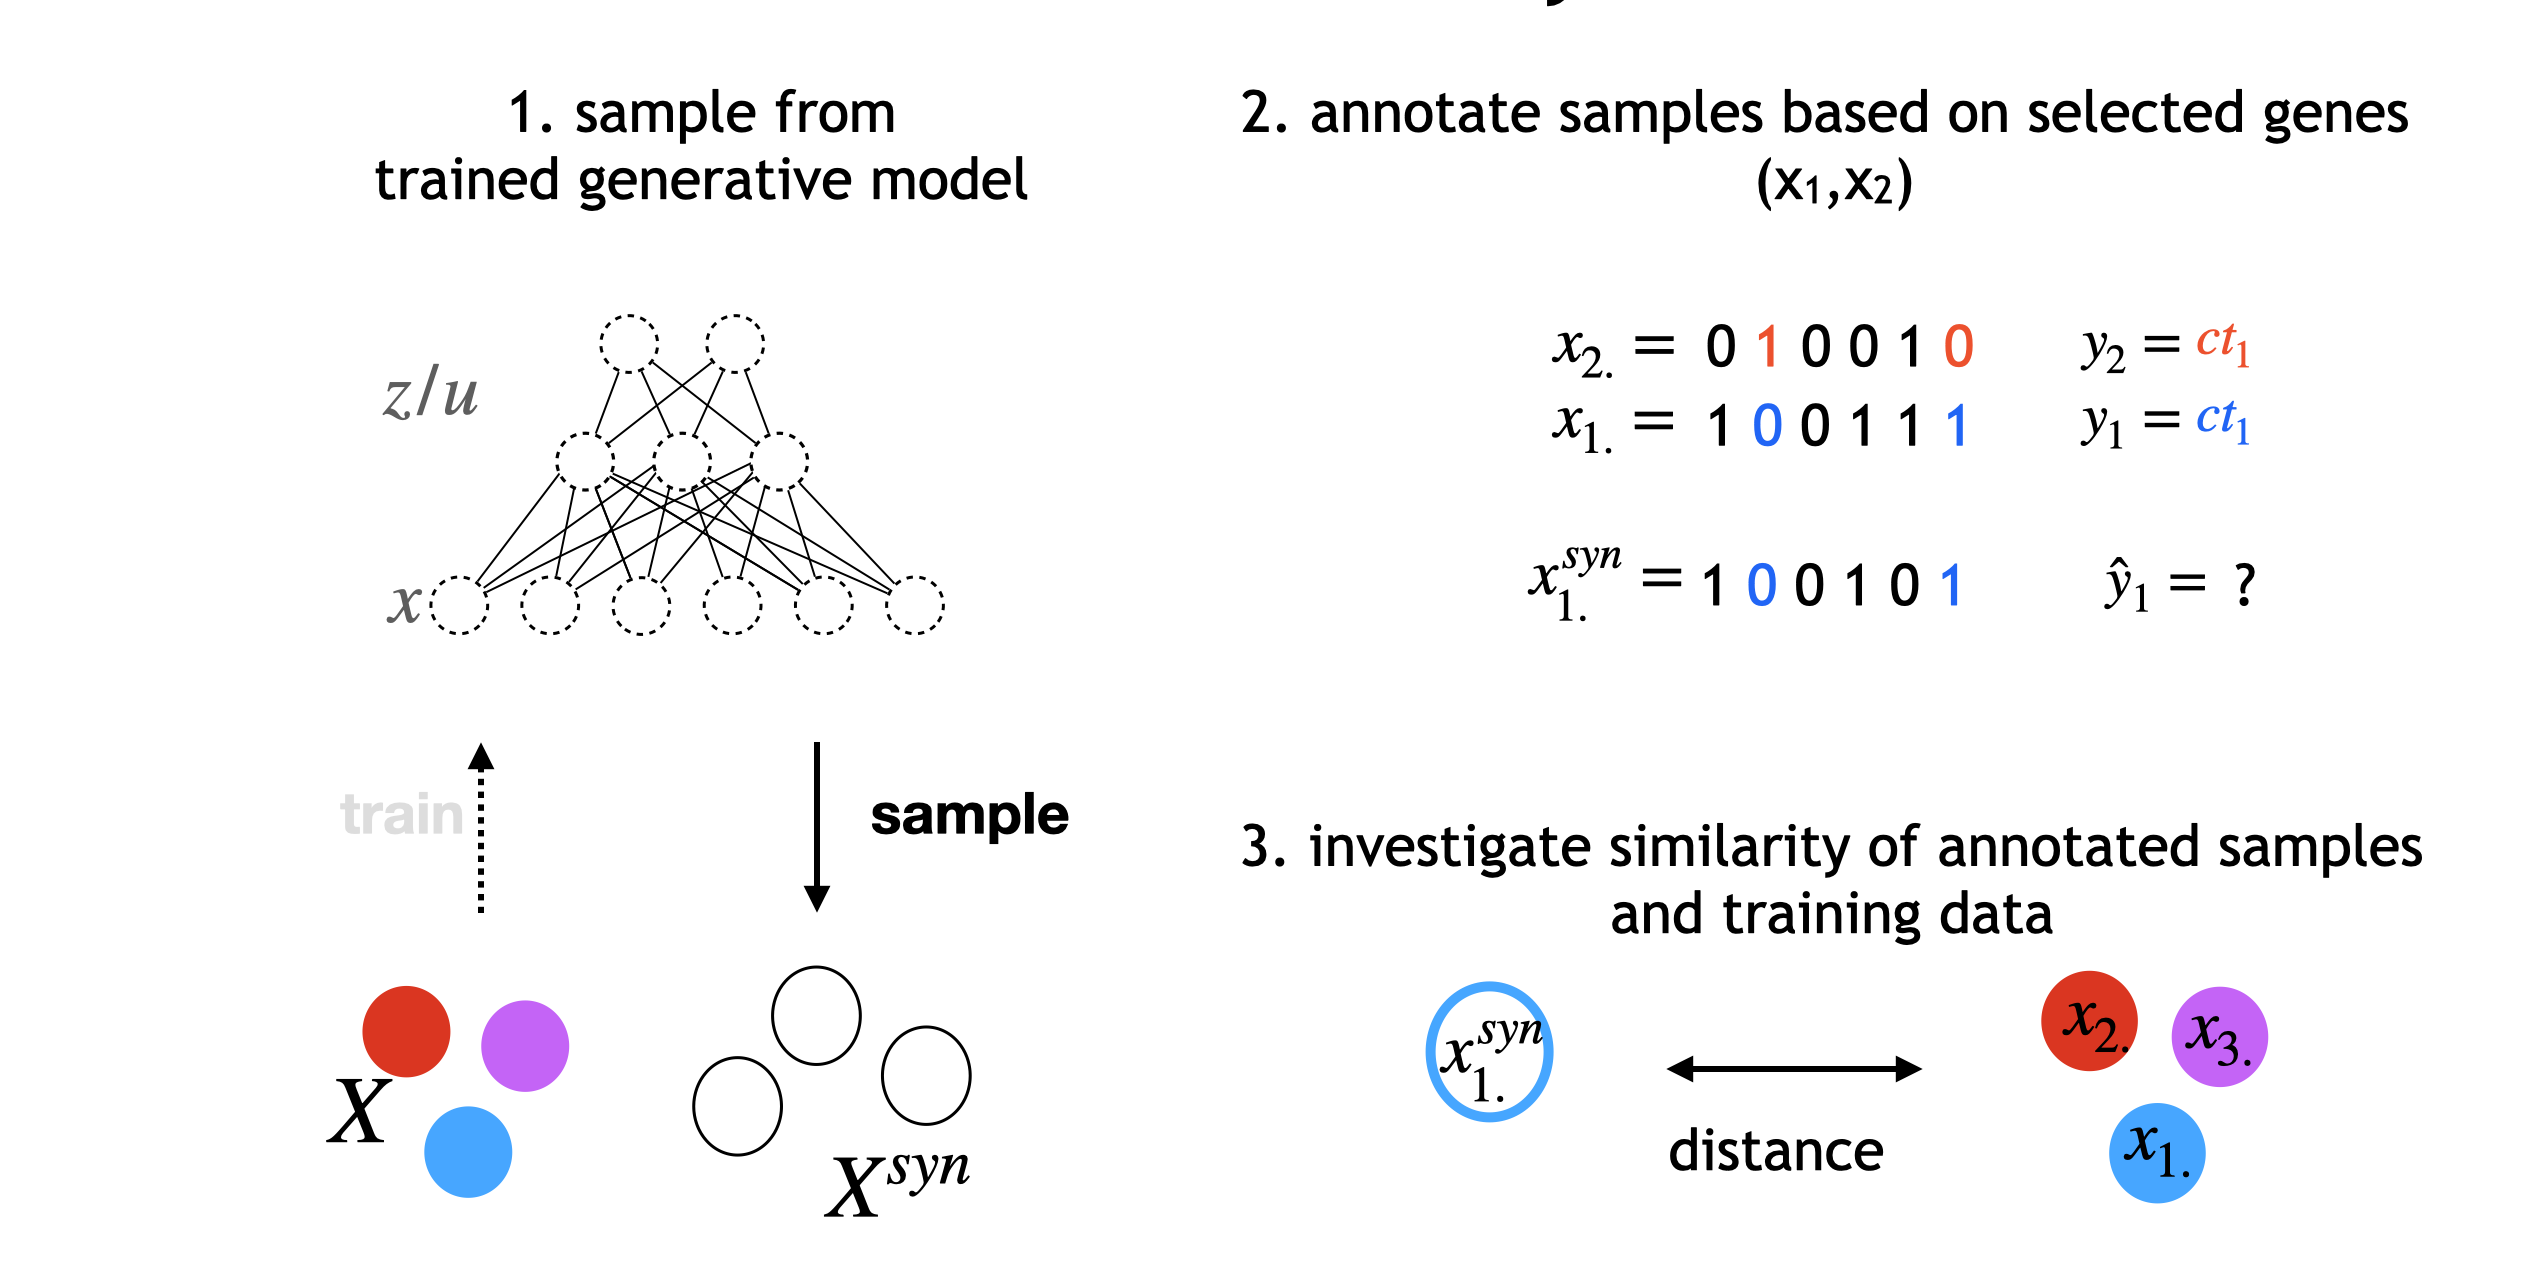
Figure 3

We only investigate a subset of samples so that the plots are not too crowded

In [29]:
samplesubset = 1:500

1:500

In [30]:
yhat = annotatesamplesbypattern(x01,xsbin[samplesubset,:],res[2],y)

500-element Vector{String}:
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 "L2/3"
 "Vip"
 "Vip"
 "Vip"
 "Vip"
 ⋮
 "Sst"
 "Pvalb"
 "Ndnf"
 "Vip"
 "Vip"
 "L5a"
 "Vip"
 "Pvalb"
 "Ndnf"
 "Vip"
 "Pvalb"
 "Vip"

Compute principal components of synthetic data for plotting

In [31]:
pcs = prcomps(xsbin)[:,1:2]

5610×2 Matrix{Float64}:
 -3.52628     1.79324
 -2.57956    -2.11722
  1.19553    -0.350159
  1.04449    -1.83071
  0.417286   -1.62759
 -3.22136    -0.0224446
  1.38415     0.503473
  0.759489   -1.34273
 -0.0316272   0.264303
  1.58108    -0.890068
 -1.70256     0.726463
 -1.71236     3.86861
  0.420961   -2.80053
  ⋮          
  1.42995    -0.126512
 -2.14397     1.42844
  0.621607    0.706977
 -2.67258    -1.71819
 -3.20568     4.63687
 -4.32404     0.731285
  1.19191     1.27402
 -0.123727   -0.00731797
  3.97372    -0.23471
  1.7805      1.1121
  2.52243    -0.885925
 -0.680834    0.2953

Restrict principal components to subset

In [32]:
pcs = pcs[samplesubset,:]

500×2 Matrix{Float64}:
 -3.52628     1.79324
 -2.57956    -2.11722
  1.19553    -0.350159
  1.04449    -1.83071
  0.417286   -1.62759
 -3.22136    -0.0224446
  1.38415     0.503473
  0.759489   -1.34273
 -0.0316272   0.264303
  1.58108    -0.890068
 -1.70256     0.726463
 -1.71236     3.86861
  0.420961   -2.80053
  ⋮          
  3.53281     3.04617
 -2.20241    -5.7247
 -2.3841     -0.709048
  1.47898    -0.277166
 -1.37321    -0.995478
  0.0398646  -0.411285
  0.862765    0.509124
 -3.55487     0.186864
  0.281       0.265108
 -3.54551     2.04668
 -0.52347    -2.31066
  2.29065     1.47606

Here we map the cell labels to colors for plotting.

In [33]:
md = Dict(
    "L4"    => "turquoise",
  "Vip"   => "darkviolet",
  "Sst"   => "gold",
  "L5a"   => "green",
  "Pvalb" => "orangered",
  "L2"    => "green",
  "L5b"   => "lightgrey",
  "Smad3" => "lightgrey",
  "Igtp"  => "lightgrey",
  "L6b"   => "lightgrey",
  "L2/3"  => "lightgrey",
  "L6a"   => "lightgrey",
  "Sncg"  => "lightgrey",
  "Ndnf"  => "lightgrey",
  "L5"    => "lightgrey"
)

Dict{String, String} with 15 entries:
  "L4"    => "turquoise"
  "Vip"   => "darkviolet"
  "Sst"   => "gold"
  "L2/3"  => "lightgrey"
  "L5a"   => "green"
  "Pvalb" => "orangered"
  "L2"    => "green"
  "L5b"   => "lightgrey"
  "L6a"   => "lightgrey"
  "Smad3" => "lightgrey"
  "Sncg"  => "lightgrey"
  "Igtp"  => "lightgrey"
  "Ndnf"  => "lightgrey"
  "L6b"   => "lightgrey"
  "L5"    => "lightgrey"

First, we assign colors to the label of real expression vectors.

In [34]:
cols = [md[i] for i = y]

1525-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "turquoise"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "green"
 "lightgrey"
 "turquoise"
 "green"
 "orangered"
 "lightgrey"
 "darkviolet"
 ⋮
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "orangered"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"

Then, we assign colors to the label of samples.

In [35]:
hatcols = [md[i] for i = yhat]

500-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 ⋮
 "gold"
 "orangered"
 "lightgrey"
 "darkviolet"
 "darkviolet"
 "green"
 "darkviolet"
 "orangered"
 "lightgrey"
 "darkviolet"
 "orangered"
 "darkviolet"

And finally we plot the first two PCs of the synthetic data sampled from a VAE, colored by the inferred labels using the log-linear models.

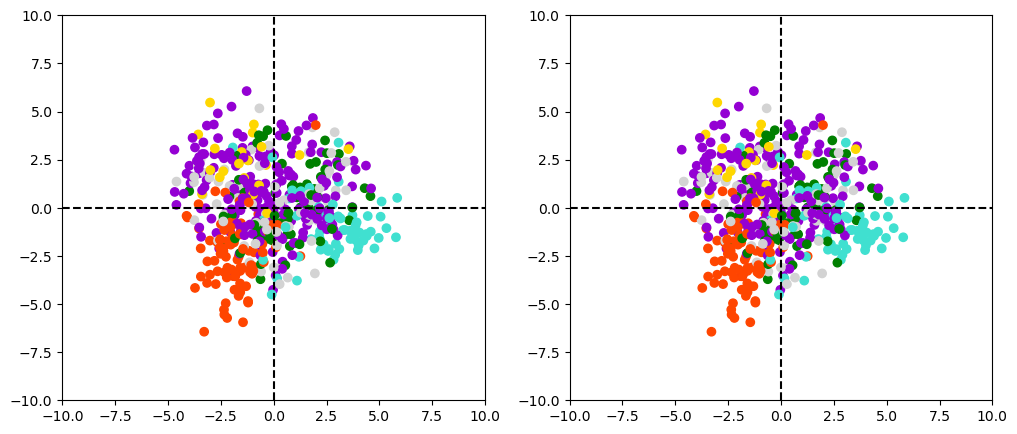

PyObject <matplotlib.lines.Line2D object at 0x19d9d1a90>

In [36]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

Plotting separately for individual cell types

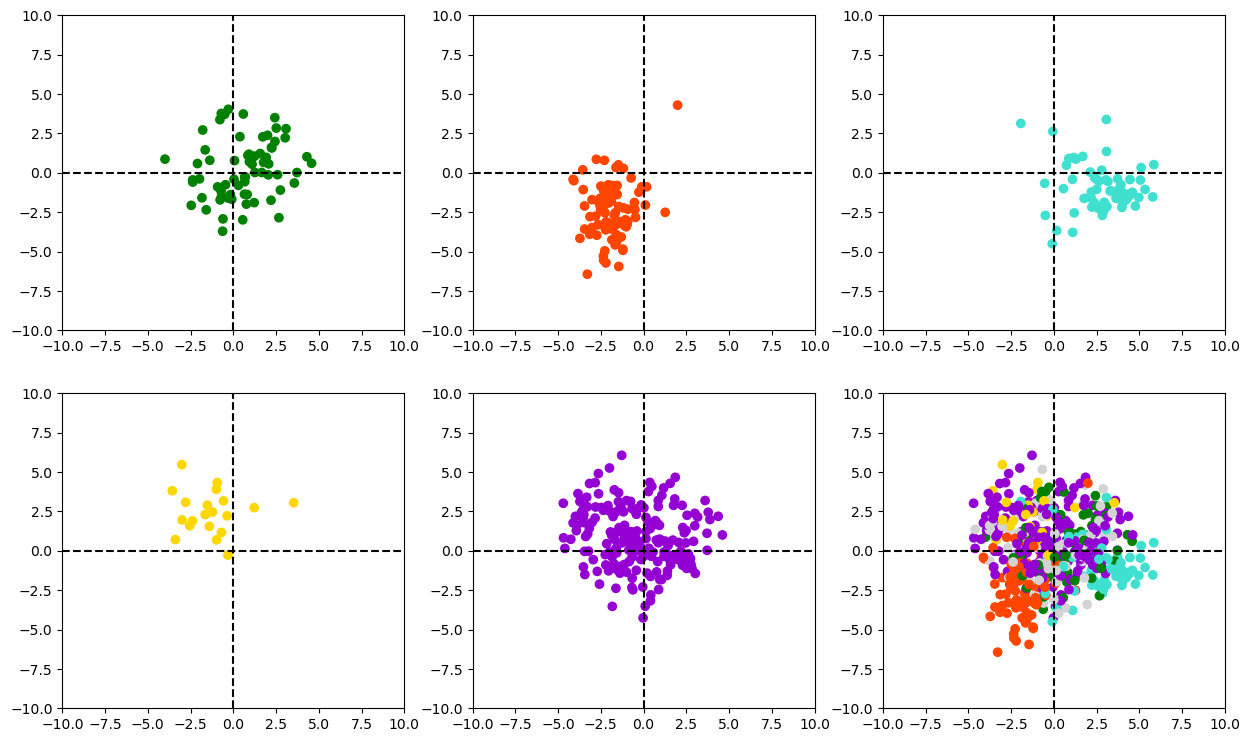

PyObject <matplotlib.lines.Line2D object at 0x19d4c2c70>

In [37]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(15, 9))
scalepar = 10
ax[1].scatter(pcs[hatcols.=="green",1],pcs[hatcols.=="green",2],c=hatcols[hatcols.=="green"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(pcs[hatcols.=="gold",1],pcs[hatcols.=="gold",2],c=hatcols[hatcols.=="gold"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(pcs[hatcols.=="orangered",1],pcs[hatcols.=="orangered",2],c=hatcols[hatcols.=="orangered"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(pcs[hatcols.=="darkviolet",1],pcs[hatcols.=="darkviolet",2],c=hatcols[hatcols.=="darkviolet"])
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

ax[5].scatter(pcs[hatcols.=="turquoise",1],pcs[hatcols.=="turquoise",2],c=hatcols[hatcols.=="turquoise"])
ax[5].set_xlim(-scalepar,scalepar)
ax[5].set_ylim(-scalepar,scalepar)
ax[5].axhline(y = 0.0,c="black",linestyle="--")
ax[5].axvline(x = 0.0,c="black",linestyle="--")

ax[6].scatter(pcs[:,1],pcs[:,2],c=hatcols)
ax[6].set_xlim(-scalepar,scalepar)
ax[6].set_ylim(-scalepar,scalepar)
ax[6].axhline(y = 0.0,c="black",linestyle="--")
ax[6].axvline(x = 0.0,c="black",linestyle="--")

We then investigate the expression matrix for the selected genes

In [38]:
selmat = zscores(log.(x[:,res[2]].+1))

1525×8 Matrix{Float64}:
 -0.518154  -0.730125   1.66205     …  -0.733749   -0.736795  -0.35042
 -0.518154  -0.834662  -0.549443        0.166873   -0.736795  -0.35042
 -0.518154   1.54239   -0.25879        -0.733749   -0.736795  -0.35042
 -0.518154  -0.64479    1.68717         1.5218     -0.496215  -0.35042
 -0.518154   1.12488    1.72289         0.90641     1.88359   -0.35042
 -0.518154  -0.739195   1.64664     …  -0.733749   -0.546357  -0.35042
 -0.518154  -0.600248   1.70527        -0.171902    1.10744   -0.35042
 -0.29645    1.10563   -0.549443       -0.733749    1.34215   -0.35042
 -0.518154  -0.330442  -0.549443       -0.733749   -0.736795  -0.35042
 -0.518154  -0.665937   1.49078        -0.615149    1.55827   -0.35042
  2.05161   -0.834662  -0.549443    …  -0.733749   -0.736795  -0.35042
 -0.518154  -0.834662  -0.549443       -0.733749    1.30082    3.34243
 -0.518154  -0.834662   1.53571        -0.733749    1.55543   -0.35042
  ⋮                                 ⋱   ⋮            

/Users/moritz/.julia/conda/3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


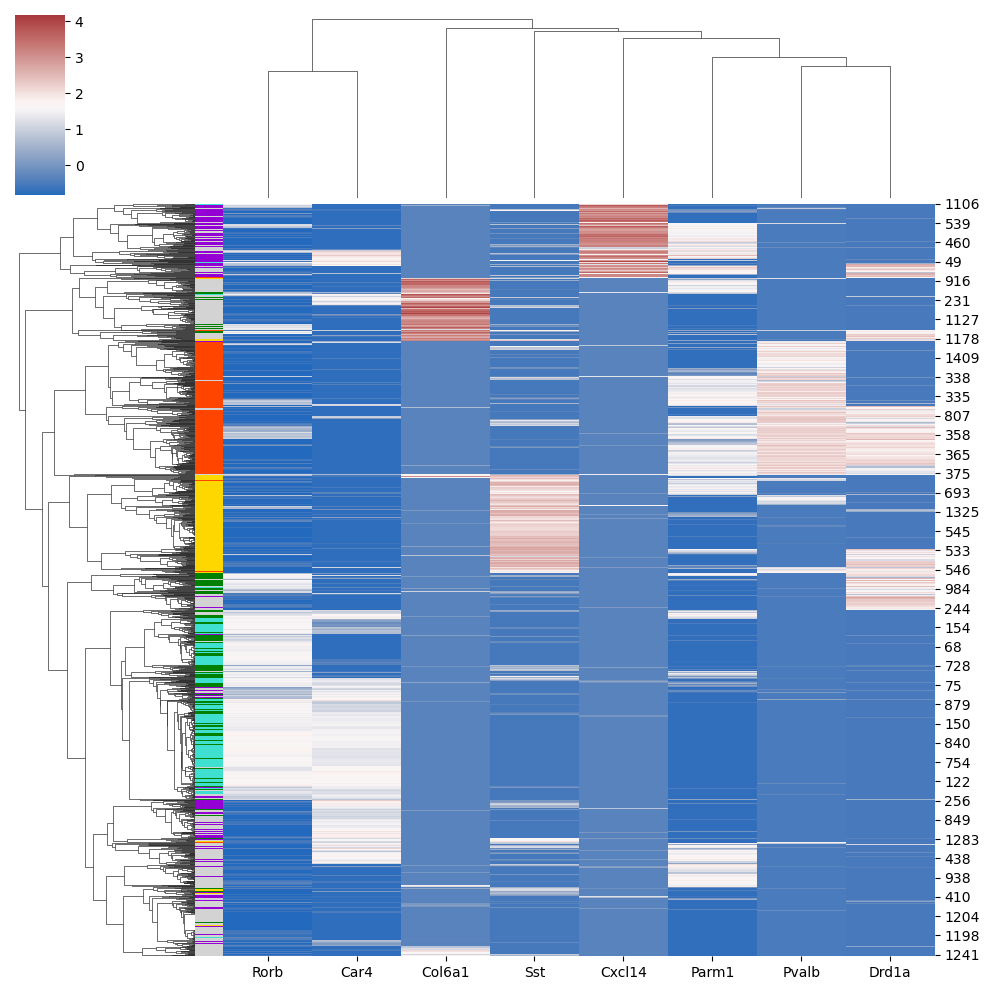

PyObject <seaborn.matrix.ClusterGrid object at 0x19d96d1f0>

In [39]:
Seaborn.clustermap(selmat,row_colors=[md[i] for i = y],cmap="vlag",xticklabels=genenames[res[2]])

## Extracting patterns from scVAEs (zero inflated negative binomial distributions)
For sc-RNASeq data, there are adaptations that can handle (zero inflated) negative binomially distributed data (scVAE) such as scVI and our adaptation for Julia which we employ here ([https://github.com/maren-ha/scVI.jl](https://github.com/maren-ha/scVI.jl)). Here we will demonstrate how to employ the ```PatternExtractor``` for extracting patterns from synthetic data sampled from an scVAE.

In [40]:
a1 = AnnData()

AnnData object with a countmatrix with nothing cells and nothing genes


In [41]:
a1.countmatrix = convert(Matrix{Float32},x)

1525×180 Matrix{Float32}:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                                  ⋱                   

In [42]:
a1.ngenes = size(x)[2]
a1.ncells = size(x)[1]

1525

First we load the expression matrix and filter to get the same genes as used for fitting the VAE for Bernoulli distributed data.

In [43]:
# a1 = scVI.load_tasic("data/")

In [44]:
# subset_tasic!(a1)

We then calculate the library size factors. In a scVAE these are important because the normalizing effect of dichotomization used for the Bernoulli VAE is not employed here.

In [45]:
# calculate library size 
library_log_means, library_log_vars = init_library_size(a1)

([11.104060173034668], [0.3126426935195923])

We then initialize the scVAE and train it on the data from Tasic et al. (2016).

In [46]:
# initialise scVAE model 
n_zs = 5
m = scVAE(size(a1.countmatrix,2);
        n_layers=1,
        library_log_means=library_log_means,
        library_log_vars=library_log_vars,
    n_hidden=70,
    n_batch=10,
    n_latent=n_zs,
    gene_likelihood=:zinb
)

# train model
training_args = TrainingArgs(
    max_epochs=50, # 50 for 10-dim 
    weight_decay=Float32(1e-6),
)
train_model!(m, a1, training_args)

#plot UMAP of latent representation 
#plot_umap_on_latent(m, a1; save_plot=true)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/moritz/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
  loss:  469.94376
┌ Info: training complete!
└ @ scVI /Users/moritz/.julia/packages/scVI/KqfV9/src/Training.jl:93


(scVAE(180, 10, 70, 5, 1, :gene, 0.1f0, true, :zinb, :normal, true, Dict{Any, Any}(), true, scEncoder(Chain(Dense(180 => 70), BatchNorm(70), identity, #39, Dropout(0.1)), Dense(70 => 5), 180, 5, 70, 1, exp, Dense(70 => 5), 0.0001f0, identity), nothing, scDecoder(5, 70, 180, 1, Chain(Dense(5 => 70), BatchNorm(70), identity, #39, Dropout(0.1)), Dense(70 => 180), Float32[-1.0417286, 0.42213398, 1.0564992, -0.95481837, 0.088506505, 1.6597656, -0.95668644, 0.36583093, -1.2426776, -0.307032  …  -0.3548887, -0.77584934, -0.13312477, -1.89544, -0.28568026, 0.43016335, 0.09570655, -0.52572626, -0.93640137, 0.71986634], Chain(Dense(70 => 180), #57), true, false)), AnnData object with a countmatrix with 1525 cells and 180 genes
)

In [47]:
x1 = a1.countmatrix

1525×180 Matrix{Float32}:
    0.0          0.0        64.0152    …  89572.3       0.0  0.0  0.0
    0.0       3379.97      466.997        17764.9       0.0  0.0  0.0
 1827.33         1.84508     0.0              0.0       0.0  0.0  0.0
    0.0          4.38998    15.9466       57210.2       0.0  0.0  0.0
    0.0          0.0       175.019        62089.7       0.0  0.0  0.0
   73.3637       0.398716    0.0       …     16.7461    0.0  0.0  0.0
  937.232        0.435715    0.0             20.9143    0.0  0.0  0.0
 2374.52         0.470643    0.0              0.941285  0.0  0.0  0.0
    0.0          0.0         0.950019         0.0       0.0  0.0  0.0
    0.799776     0.0         0.399888         9.59731   0.0  0.0  0.0
  250.506        0.0         0.0       …      0.0       0.0  0.0  0.0
  497.253        0.0        12.8967           0.0       0.0  0.0  0.0
    0.0          4.62896     0.0          49361.4       0.0  0.0  0.514329
    ⋮                                  ⋱                   

Here we infer the states of the latent variables (z), based on the observed gene expression data. This is equivalent to draw from the posterior distribution of the latent variables.

In [48]:
infres = scVI.inference(m,Transpose(x1))

(Float32[-3.8217416 -2.2753942 … -2.8214908 -3.3698409; 3.259824 3.814917 … 0.19421929 1.1557368; … ; -4.679905 -2.0507276 … -2.3449962 -3.0270298; 1.3885031 -0.41742626 … 1.7167611 0.7323773], Float32[-3.751556 -2.4106798 … -2.6759446 -3.5790079; 3.2160664 3.6239028 … 1.0243808 1.0394685; … ; -4.700964 -2.2374444 … -2.3793664 -3.2320356; 1.4986935 -0.5078412 … 1.7409799 0.53493845], Float32[0.009678321 0.018791618 … 0.02252598 0.01942163; 0.030701412 0.04374477 … 0.35351178 0.14788519; … ; 0.023759695 0.032858897 … 0.032137856 0.11531186; 0.05783679 0.042044554 … 0.088539235 0.02866161], nothing, nothing, Float32[12.59725 11.704754 … 11.649896 11.77221])

In [49]:
infres[1]

5×1525 Matrix{Float32}:
 -3.82174  -2.27539    1.53994  -2.68103   …  -2.81838   -2.82149   -3.36984
  3.25982   3.81492   -2.2864    3.4467        0.363111   0.194219   1.15574
 -1.13296  -1.18684   -3.34612   0.396205     -0.166026   1.66006    1.3138
 -4.6799   -2.05073    0.57711  -4.09726      -2.43504   -2.345     -3.02703
  1.3885   -0.417426  -2.49333  -0.481391      1.63585    1.71676    0.732377

We inspect the covariance of the latent variables.

In [50]:
covz = cov(Transpose(infres[1]))

5×5 Matrix{Float32}:
  4.26978   -0.602372  -0.706265   1.75054   0.649193
 -0.602372   7.45429    1.54605   -2.11487   2.33849
 -0.706265   1.54605    5.43796   -1.271     2.30713
  1.75054   -2.11487   -1.271      3.93089  -1.10334
  0.649193   2.33849    2.30713   -1.10334   4.27065

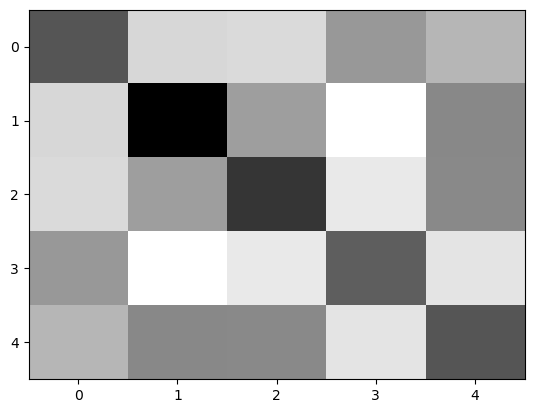

PyObject <matplotlib.image.AxesImage object at 0x19dc72cd0>

In [51]:
PyPlot.figure()
PyPlot.imshow(cov(Transpose(infres[1])),aspect="auto",cmap="binary")

Alternatively we can draw from the prior distribution, which is basically sampling from a multivariate normal distribution.

In [52]:
normdist = rand(MultivariateNormal(fill(0,size(covz)[1]),covz),10000)

5×10000 Matrix{Float32}:
 0.445406  -0.867378  3.3384    0.795065  …  -0.476473  -3.47139  -0.316829
 0.554455  -0.71414   3.50603  -2.33651      -1.01205    2.09689   0.214243
 0.330773   1.37404   2.38519   0.401946     -1.22065    2.12989   0.851529
 0.426792   5.2677    0.30075   1.08016      -1.94072   -2.84292   0.648675
 1.02197    1.89756   1.69773   0.727983     -2.34026    2.33057   0.230123

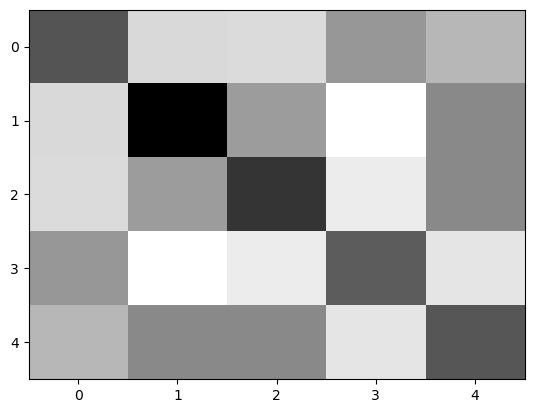

PyObject <matplotlib.image.AxesImage object at 0x19e0c1d60>

In [53]:
PyPlot.figure()
PyPlot.imshow(cov(Transpose(normdist)),aspect="auto",cmap="binary")

For sampling from a negative binomial distribution, we need the library size, which is essentially a scaling factor.

In [54]:
libsize = sum(x1,dims=2)

1525×1 Matrix{Float32}:
 295744.1
 121146.22
  81335.984
 169927.66
 154057.33
  84935.65
  79330.07
  73362.26
  35174.527
  71338.31
  42179.902
  49352.33
 140304.02
      ⋮
  59410.133
  66530.61
  36251.2
  56015.723
  43128.215
  67526.836
 146509.1
 115469.57
 105664.9
 128478.92
 114679.414
 129600.21

When we sample from the prior distribution, of course there is no library size available, thus we inspect the distribution of the library sizes in the Tasic et al. data and then sample from a normal distribution with similar expected value and standard deviation.

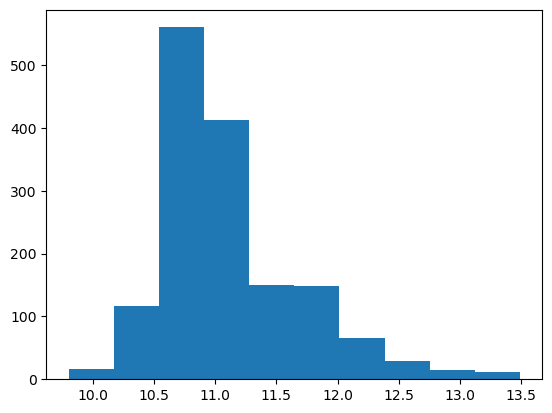

([16.0, 117.0, 560.0, 413.0, 150.0, 149.0, 66.0, 29.0, 14.0, 11.0], Float32[9.803326, 10.172036, 10.540746, 10.909456, 11.278166, 11.646876, 12.015587, 12.384296, 12.753007, 13.1217165, 13.490427], (PyObject <matplotlib.patches.Rectangle object at 0x17dc0b100>, PyObject <matplotlib.patches.Rectangle object at 0x19e11bf40>, PyObject <matplotlib.patches.Rectangle object at 0x17dc0b490>, PyObject <matplotlib.patches.Rectangle object at 0x17dc0b6a0>, PyObject <matplotlib.patches.Rectangle object at 0x17dc0b8b0>, PyObject <matplotlib.patches.Rectangle object at 0x17dc0bac0>, PyObject <matplotlib.patches.Rectangle object at 0x17dc0bcd0>, PyObject <matplotlib.patches.Rectangle object at 0x17dc0bee0>, PyObject <matplotlib.patches.Rectangle object at 0x19e137130>, PyObject <matplotlib.patches.Rectangle object at 0x19e137340>))

In [55]:
PyPlot.figure()
PyPlot.hist(log.(libsize))

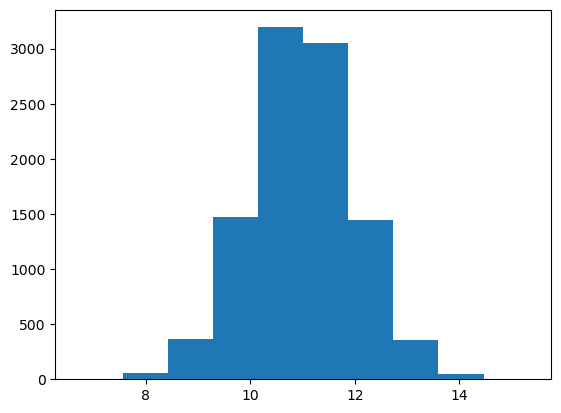

([4.0, 59.0, 366.0, 1468.0, 3194.0, 3050.0, 1446.0, 359.0, 48.0, 6.0], [6.703844793717037, 7.565692299362985, 8.427539805008934, 9.289387310654881, 10.151234816300828, 11.013082321946776, 11.874929827592725, 12.736777333238672, 13.598624838884621, 14.460472344530569, 15.322319850176516], (PyObject <matplotlib.patches.Rectangle object at 0x19e194a60>, PyObject <matplotlib.patches.Rectangle object at 0x19e1856d0>, PyObject <matplotlib.patches.Rectangle object at 0x19e194dc0>, PyObject <matplotlib.patches.Rectangle object at 0x19e194fa0>, PyObject <matplotlib.patches.Rectangle object at 0x19e1a3250>, PyObject <matplotlib.patches.Rectangle object at 0x19e1a3460>, PyObject <matplotlib.patches.Rectangle object at 0x19e1a3670>, PyObject <matplotlib.patches.Rectangle object at 0x19e1a3880>, PyObject <matplotlib.patches.Rectangle object at 0x19e1a3a90>, PyObject <matplotlib.patches.Rectangle object at 0x19e1a3ca0>))

In [56]:
PyPlot.figure()
PyPlot.hist(rand(Distributions.Normal(11,1),10000))

If we sample the observed variables based on the prior distribution of the latent variables, we assume an arbitrary value for the scaling factor, which we draw from a Normal Distribution with expected value of 11 and standard deviation 1.

In [57]:
prior1 = scVI.decodersample(m,normdist,convert(Matrix{Float32},Transpose(rand(Distributions.Normal(11,1),10000))))

180×10000 Matrix{Int64}:
  11  287    0  79  133  2340   0  1214  …     0    0     0  2005     0   10
  34    0   39   0    0     0  43     0      952  120     0   217     0    0
  22    0    0  10    0    42  14    23      340    0   494   346    72    0
   0    0    0  22    0     0   0     0        0    0     0     0     0    0
   0    0    0   0    0     0   0     0        0    0     0     0     0   10
   0    0   38  46    0   141   0     0  …     0   21     0     0     0    0
   0    0    0   0    0     0   0     0        0    0     0     0     0    0
   0    0    0   0    0     0   0     0       46    0     4   917     0    0
 112    0    0  35    0     1   0   367        0    0    65     0     0    0
   0    0    0   0    0     0   0     0        0    0     0     0     0    0
   0    0  112   0    0     0  31     0  …     0  168     0     0     2   50
   2    0    0   2    0     1   0     1       58    0     0     0     0    0
  72    0    0   0    0     0   0     0        0   

Here we sample the values for the observed variables conditional on a draw from the posterior distribution.

In [58]:
post1 = scVI.decodersample(m,infres[1],Transpose(log.(libsize)))

180×1525 Matrix{Int64}:
     0    0  173      0       0  138  …      0     0     0      0    0     0
     0    0  147    406     351    0        88     0     0    528    0     0
   596  384    7    133      87   24        44   246   147    349   38     0
     0    0    0      0       0    0         0     0     0      0    0     0
     0    0    0      0       0    0         0     0  1129    115    0     0
    46    0    0      0       0   39  …      0    56     0     45    0     0
     0    0    0      0       0    0         0     0     0      0    0     0
     0    2    0      0       0    4         0     2    94      2    0     0
   124  341  295      0       0    5         0     8     0      0  126     0
     0    0    0      0       0    0         0     0     0      0    0     0
     0   93    0     21       0    0  …      0     0    57      0  260    61
     0    0    0      0       0    0         0     0     0      0    0     0
     0    0    0      0       0    0         0     0

In order to investigate the quality of the learnt distribution, we can compare the covariance matrix computed from the sampled synthetic observations with the covariance matrix computed from the original data.

In [59]:
cmats=cov(Transpose(log.(post1.+1)))

180×180 Matrix{Float64}:
  8.51679    -2.0106      -2.25858    …  -0.112311     -0.0391871
 -2.0106      6.03075      0.788907       0.213755      0.0312024
 -2.25858     0.788907     4.05343        0.0730267    -0.0241605
  0.583404   -0.367335    -0.358597      -0.00215763    0.00554552
  0.0645314  -0.215994     0.0942656     -0.00498871   -0.0221862
  1.01742    -0.53724     -0.723754   …   0.0318748     0.00318799
  0.0396103  -0.0355479   -0.0160637     -0.00756952    0.00366604
 -0.0926002   0.0930466    0.153357       0.0362204    -0.00229684
  0.777972   -0.270797    -0.629111       0.00076119    0.0602906
  0.177027   -0.0613188   -0.0363398     -0.0170173    -0.00917772
 -0.746516    0.839568     0.171849   …   0.055865      0.0609154
  0.0415497  -0.111905    -0.0265155     -0.000418762  -0.0111272
  0.0596587   0.0294684    0.0123518      0.0273918     0.0220248
  ⋮                                   ⋱                
 -0.579817    0.364111     0.462155      -0.0237777    -

In [60]:
cmat = cov(log.(x1.+ 1))

180×180 Matrix{Float32}:
  9.74901    -2.30395     -2.36882     …  -0.0550508     0.0224171
 -2.30395     5.17761      0.821996        0.23014       0.0559934
 -2.36882     0.821996     3.54817        -0.0622513     0.0119462
  0.867629   -0.246475    -0.376976       -7.90805f-5    0.0123659
  0.367547   -0.17832      0.0765757      -0.0480148    -0.0140216
  1.23876    -0.428879    -0.454277    …   0.0215122     0.0593106
  0.0478442  -0.0345746   -0.0217872      -0.00570485   -0.00232604
 -0.209837    0.134364     0.0629303       0.0249866     0.0323814
  0.98618     0.0654653   -0.457241        0.136795     -0.00806783
  0.180902   -0.0925702   -0.0762379      -0.0138768     0.00861435
 -1.11035     1.08158      0.220494    …   0.175086      0.0712893
  0.0793958  -0.0473672   -0.00682154     -0.0126866     0.0257686
 -0.0697931   0.107343     0.00637307      0.0294069     0.000516367
  ⋮                                    ⋱                
 -0.845961    0.134045     0.503138       

In [61]:
order = cluster_matrix(cmat)[4]

180-element Vector{Int64}:
  20
 163
  37
 177
  15
 147
 155
   1
 101
  17
  64
  68
 100
   ⋮
 108
  51
  83
  89
 143
 150
  71
  63
  66
  53
  65
  85

Here we investigate the corresponding matrices which are oriented according to the clustering of the genes in the original data used for training.

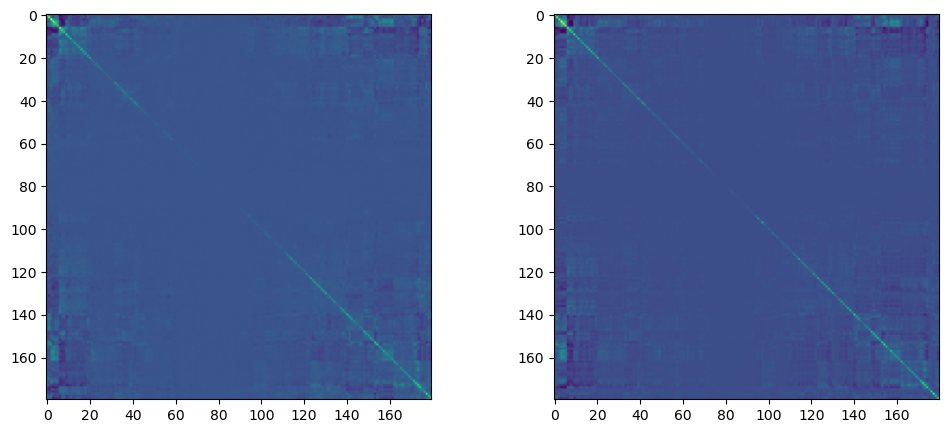

PyObject <matplotlib.image.AxesImage object at 0x19e339ac0>

In [62]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[1].imshow(cmat[order,order])
ax[2].imshow(cmats[order,order])

We format the samples drawn from the scVAE.

In [63]:
#zs = float.(Transpose(infres[1]))
zs = Transpose(normdist)
xs = float.(Transpose(prior1))

10000×180 Matrix{Float64}:
   11.0   34.0   22.0   0.0    0.0  …     0.0  0.0     0.0  0.0  27.0  0.0
  287.0    0.0    0.0   0.0    0.0        0.0  0.0     0.0  0.0   0.0  0.0
    0.0   39.0    0.0   0.0    0.0        0.0  0.0     0.0  0.0   0.0  0.0
   79.0    0.0   10.0  22.0    0.0        0.0  0.0    29.0  0.0   0.0  0.0
  133.0    0.0    0.0   0.0    0.0        0.0  0.0     0.0  0.0   0.0  0.0
 2340.0    0.0   42.0   0.0    0.0  …     0.0  0.0     0.0  0.0   4.0  0.0
    0.0   43.0   14.0   0.0    0.0        0.0  0.0     0.0  0.0   0.0  0.0
 1214.0    0.0   23.0   0.0    0.0        0.0  0.0     0.0  0.0   0.0  0.0
    1.0    0.0    1.0   0.0    0.0        0.0  0.0     0.0  0.0   0.0  0.0
  194.0    0.0    0.0   0.0  402.0        0.0  0.0     0.0  0.0   0.0  0.0
    3.0    0.0    0.0   0.0    0.0  …     0.0  0.0   347.0  0.0   0.0  0.0
    0.0  185.0  159.0   0.0    0.0        0.0  0.0   388.0  0.0   0.0  0.0
 4119.0  205.0   41.0   0.0  148.0        0.0  0.0     0.0  0.0   0.0  0.

We then dichotomize the synthetic observations, here in contrast to the Bernoulli VAE we perform the discretization after training.

In [64]:
zsbin = float.(ifelse.(zs.>0,1,0))

10000×5 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0  1.0
 1.0  0.0  0.0  1.0  0.0
 1.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  1.0
 1.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0
 ⋮                   
 1.0  1.0  0.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0
 1.0  0.0  1.0  1.0  1.0
 0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  1.0
 0.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  1.0
 0.0  1.0  1.0  1.0  1.0

In [65]:
xsbin = dichotomize(xs,selquantile=dichoquantile)

10000×180 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  0

We inspect the number we obtain a "1" for each gene.

In [66]:
sum(xsbin,dims=1)

1×180 Matrix{Float64}:
 1999.0  1997.0  2000.0  1405.0  995.0  …  181.0  1999.0  190.0  312.0  396.0

We now extract the patterns between observed and latent variables from the discretized synthetic observations.

We again set the only hyperparameter which is the number of variables we want to extract

In [67]:
nvars= 8

8

In [68]:
res = extract_pattern(nvars,xsbin,zsbin)

([2335.8117996200695, 1774.6027741210783, 1622.8240949536748, 1124.0450235284075, 1083.201974166852, 976.8214564276783, 641.3988867916655, 583.3462700031652], [155, 150, 147, 177, 152, 90, 100, 15], Any[[172.12631296953953 672.4530830676866 … 353.5615423290627 193.64067937338268; 2.5471322304907957 592.562428198881 … 178.4286754418536 25.71157594351402; … ; 48.75234431198051 79.81964411121729 … 28.447352163780764 0.9774649644500641; 3.01490020917705 0.4493085040526523 … 48.17654673445482 18.030194515473667], [214.1157960388543 424.67659671538195 … 240.2580262518943 39.13317965064782; 2.0429967795548407 539.149797655378 … 150.63793515468058 8.373115415264024; … ; 51.61975554919127 74.96396073270398 … 29.611084661406043 3.82715743813195; 3.4107988268488976 0.48649128577331524 … 64.23609072800359 20.833256439174157], [263.3598215374459 419.54458491703406 … 238.31172541007453 33.36302590362922; 31.640049297183218 318.13535894394295 … 145.95241876332864 5.709544809750039; … ; 31.05058513455

We inspect the genes we extracted

In [69]:
genenames[res[2]]

8-element Vector{Any}:
 "Rorb"
 "Pvalb"
 "Penk"
 "Vip"
 "Reln"
 "Grik3"
 "Grm2"
 "Calb2"

> **Exercise:** 
>
> Compare the extracted genes, with the genes extracted with the Bernoulli VAE. Are there differences ? If so, what could be the reason ?

In [70]:
selmat = zscores(log.(x[:,res[2]].+1))

1525×8 Matrix{Float64}:
 -0.730125  -0.518154   2.34773    …   1.28643     -0.494373   2.44899
 -0.834662  -0.518154  -0.503833      -0.859034    -0.494373  -0.0948806
  1.54239   -0.518154  -0.503833      -0.221142     2.83737   -0.493229
 -0.64479   -0.518154   2.53681       -0.675609    -0.494373   2.41725
  1.12488   -0.518154  -0.397258      -0.777394    -0.494373   2.33339
 -0.739195  -0.518154   0.109696   …  -0.310902    -0.330354   0.722481
 -0.600248  -0.518154  -0.175309      -0.65314     -0.494373   0.806694
  1.10563   -0.29645   -0.503833      -0.510228    -0.494373  -0.493229
 -0.330442  -0.518154  -0.503833      -0.579228     1.49038   -0.493229
 -0.665937  -0.518154  -0.0692333     -0.541866    -0.494373  -0.0558884
 -0.834662   2.05161   -0.503833   …   1.67089     -0.494373   1.3575
 -0.834662  -0.518154  -0.503833      -0.584239    -0.494373  -0.493229
 -0.834662  -0.518154   2.32081       -0.526547    -0.494373   2.40095
  ⋮                                ⋱   ⋮    

We again inspect the expression in the selected genes.

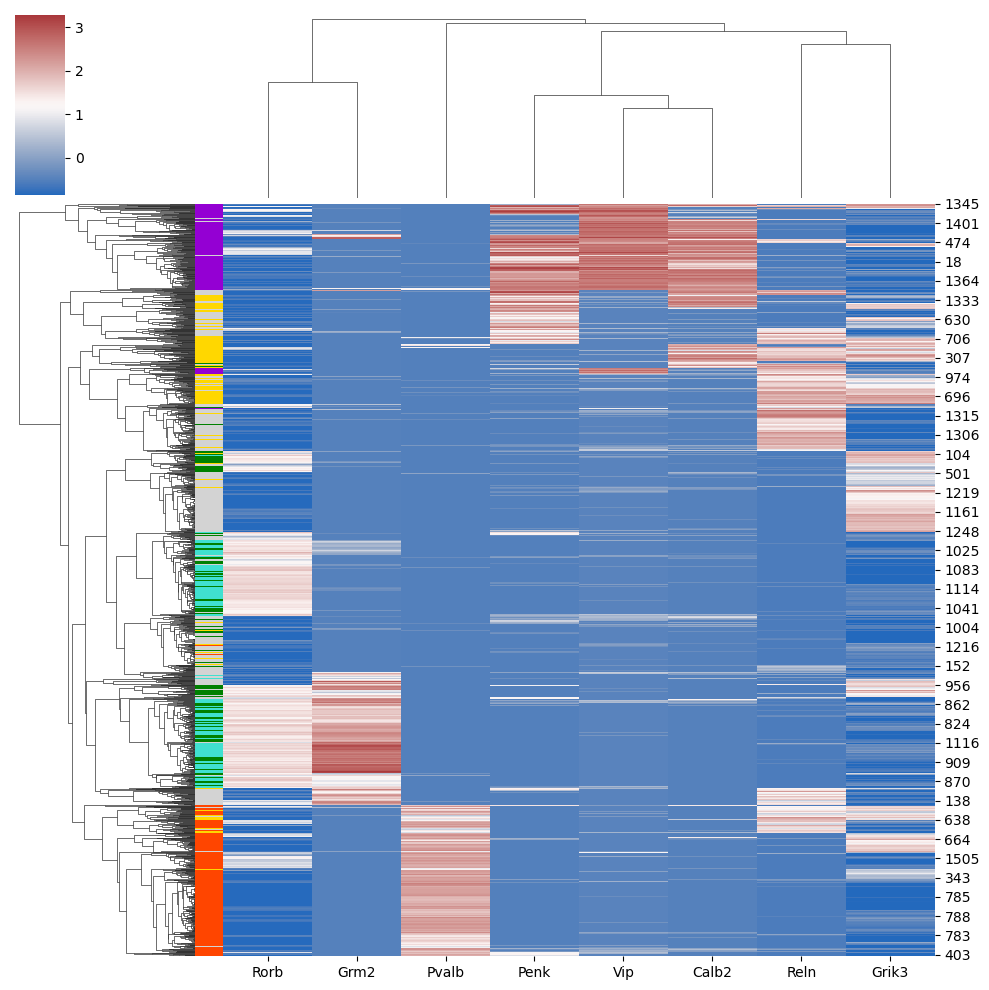

PyObject <seaborn.matrix.ClusterGrid object at 0x19e32c970>

In [71]:
Seaborn.clustermap(selmat,row_colors=[md[i] for i = y],cmap="vlag",xticklabels=genenames[res[2]])

Then we do also annotate synthetic observations with patterns in the extracted genes.

In [72]:
xbin = dichotomize(x1,selquantile=dichoquantile) 

1525×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [73]:
xsbin = dichotomize(Transpose(post1),selquantile=dichoquantile)

1525×180 Matrix{Float64}:
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0     1.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     1.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.

In [74]:
yhat = annotatesamplesbypattern(xbin,xsbin[samplesubset,:],res[2],y)

500-element Vector{String}:
 "Vip"
 "Vip"
 "L5a"
 "Vip"
 "Vip"
 "Igtp"
 "Igtp"
 "L5a"
 "Igtp"
 "Igtp"
 "Pvalb"
 "L5a"
 "Vip"
 ⋮
 "Igtp"
 "Vip"
 "Igtp"
 "Pvalb"
 "Sst"
 "L5a"
 "Vip"
 "Vip"
 "Vip"
 "Sst"
 "Vip"
 "Sst"

In [75]:
countmap(yhat)

Dict{String, Int64} with 14 entries:
  "L4"    => 53
  "Vip"   => 121
  "Sst"   => 32
  "L5b"   => 15
  "L5a"   => 79
  "Pvalb" => 98
  "L2"    => 2
  "Smad3" => 1
  "Igtp"  => 71
  "L6b"   => 2
  "L2/3"  => 3
  "L6a"   => 14
  "Ndnf"  => 3
  "L5"    => 6

In [76]:
md = Dict(
    "L4"    => "turquoise",
  "Vip"   => "darkviolet",
  "Sst"   => "gold",
  "L5a"   => "forestgreen",
  "Pvalb" => "orangered",
  "L2"    => "green",
  "L5b"   => "lightgrey",
  "Smad3" => "lightgrey",
  "Igtp"  => "lightgrey",
  "L6b"   => "lightgrey",
  "L2/3"  => "lightgrey",
  "L6a"   => "lightgrey",
  "Sncg"  => "lightgrey",
  "Ndnf"  => "lightgrey",
  "L5"    => "lightgrey"
)

Dict{String, String} with 15 entries:
  "L4"    => "turquoise"
  "Vip"   => "darkviolet"
  "Sst"   => "gold"
  "L2/3"  => "lightgrey"
  "L5a"   => "forestgreen"
  "Pvalb" => "orangered"
  "L2"    => "green"
  "L5b"   => "lightgrey"
  "L6a"   => "lightgrey"
  "Smad3" => "lightgrey"
  "Sncg"  => "lightgrey"
  "Igtp"  => "lightgrey"
  "Ndnf"  => "lightgrey"
  "L6b"   => "lightgrey"
  "L5"    => "lightgrey"

In [77]:
hatcols = [md[i] for i = yhat]

500-element Vector{String}:
 "darkviolet"
 "darkviolet"
 "forestgreen"
 "darkviolet"
 "darkviolet"
 "lightgrey"
 "lightgrey"
 "forestgreen"
 "lightgrey"
 "lightgrey"
 "orangered"
 "forestgreen"
 "darkviolet"
 ⋮
 "lightgrey"
 "darkviolet"
 "lightgrey"
 "orangered"
 "gold"
 "forestgreen"
 "darkviolet"
 "darkviolet"
 "darkviolet"
 "gold"
 "darkviolet"
 "gold"

In [78]:
countmap(hatcols)

Dict{String, Int64} with 7 entries:
  "lightgrey"   => 115
  "gold"        => 32
  "darkviolet"  => 121
  "forestgreen" => 79
  "green"       => 2
  "orangered"   => 98
  "turquoise"   => 53

In [79]:
pcs = prcomps(Transpose(log.(post1 .+1)))

1525×180 Matrix{Float64}:
 -5.87719   -1.82232    1.76235    …   0.184298  -0.459581    0.736614
 -5.02935    0.879998   3.44664        1.14679    0.308139    1.09276
  2.9389     0.317964   1.13764        0.718786  -0.506939    0.439785
 -6.27086   -3.13978    2.65794       -0.429519  -0.321929    0.166439
 -4.83152   -4.45107    3.44637        1.20951   -1.22674    -0.36396
  0.401262  -2.69298   -1.07979    …  -0.264316   1.1862      0.177503
  1.96546   -1.51779   -1.29739        0.277387   0.0239971   0.0507219
  3.87739   -1.86505    1.24379       -0.368764  -0.427494    0.354514
  3.31752   -0.658702  -1.12094        0.391174   0.454243   -0.252624
  1.66343   -1.17932   -1.62611       -0.472122  -0.543946    0.651092
  0.85442    3.6172     0.242115   …   0.243772  -0.43443     0.553287
  3.16678   -3.1403    -2.84178        0.136862  -0.143236    0.146714
 -6.21563   -3.80621    0.456937       0.9094     1.05424    -1.27296
  ⋮                                ⋱                 

In [80]:
pc1 = pcs[samplesubset,:]

500×180 Matrix{Float64}:
 -5.87719   -1.82232     1.76235   …   0.184298   -0.459581    0.736614
 -5.02935    0.879998    3.44664       1.14679     0.308139    1.09276
  2.9389     0.317964    1.13764       0.718786   -0.506939    0.439785
 -6.27086   -3.13978     2.65794      -0.429519   -0.321929    0.166439
 -4.83152   -4.45107     3.44637       1.20951    -1.22674    -0.36396
  0.401262  -2.69298    -1.07979   …  -0.264316    1.1862      0.177503
  1.96546   -1.51779    -1.29739       0.277387    0.0239971   0.0507219
  3.87739   -1.86505     1.24379      -0.368764   -0.427494    0.354514
  3.31752   -0.658702   -1.12094       0.391174    0.454243   -0.252624
  1.66343   -1.17932    -1.62611      -0.472122   -0.543946    0.651092
  0.85442    3.6172      0.242115  …   0.243772   -0.43443     0.553287
  3.16678   -3.1403     -2.84178       0.136862   -0.143236    0.146714
 -6.21563   -3.80621     0.456937      0.9094      1.05424    -1.27296
  ⋮                                ⋱     

In [81]:
pc2 = prcomps(log.(a1.countmatrix .+1))

1525×180 Matrix{Float32}:
 -7.17064     4.30943    2.6273    …   0.259412   -0.450207    0.411478
 -4.76982     3.24113    2.95963       0.86309    -0.558356   -1.11742
  4.19574     1.87985   -0.550503      0.203376   -0.364234   -0.11371
 -6.12385     2.01034    2.82508       0.283937    0.295076   -0.0831489
 -4.73361     4.35474    0.385151     -0.234467    1.43586    -0.401565
  2.86774     1.32854   -0.674349  …   0.14303    -0.387307   -0.271185
  1.25634     0.497637  -0.715663      0.310112    0.0725875  -0.0752082
  4.94999     1.68719    0.212023     -0.0484311  -0.454667   -0.0879959
  2.52716     1.41128   -0.175875      0.202563   -0.366347    0.0723796
  1.22248     0.247205  -2.06984      -0.256135    0.935158   -0.0934877
 -1.24361    -3.13007    1.71753   …  -0.401837   -0.420962    0.561767
  2.67983     1.56398   -0.256157      0.0815822  -0.258845    0.124253
 -3.55751     2.75245    0.722695      0.243689    0.276902    0.175056
  ⋮                                

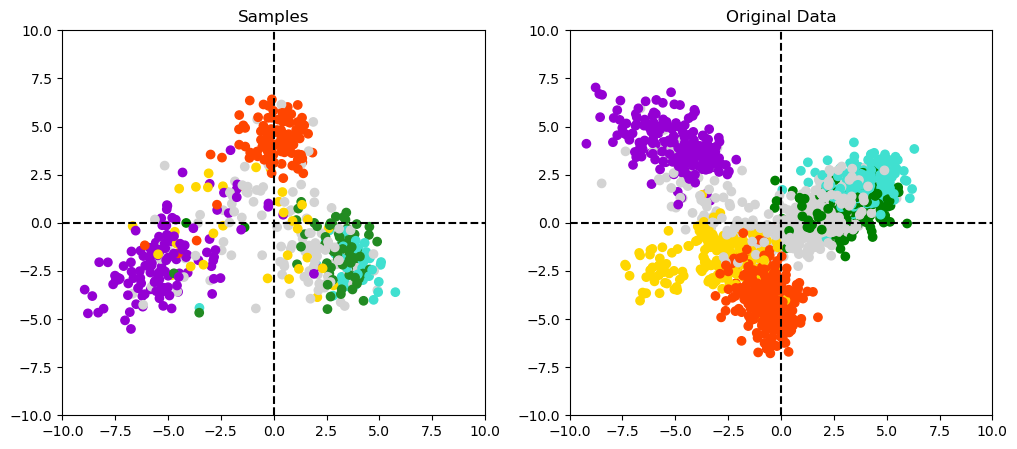

PyObject <matplotlib.lines.Line2D object at 0x19d6742e0>

In [82]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=1, ncols=2, figsize=(12, 5))
scalepar = 10
ax[1].scatter(pc1[:,1],pc1[:,2],c=hatcols)
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].set_title("Samples")
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")
ax[2].scatter(pc2[:,1],pc2[:,2],c=cols)
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].set_title("Original Data")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

Instead of using PCA for dimension reduction, we could also use the trained encoder for dimension reduction.

In [83]:
latents = Transpose(get_latent_representation(m,x1))[samplesubset,:]

500×5 Matrix{Float32}:
 -3.75156     3.21607   -0.680137  -4.70096     1.49869
 -2.41068     3.6239    -1.31166   -2.23744    -0.507841
  1.56788    -2.64618   -2.97832    0.280431   -2.58409
 -2.57921     3.62941    0.679594  -4.11071    -0.19913
 -4.3879      0.955593  -0.469294  -2.52807    -0.779227
 -0.723126   -4.52387    1.11534    0.849717   -0.538318
 -1.78344    -2.36122    2.97794    1.36422    -1.43169
  0.659489   -5.8211    -1.05396    0.661385   -3.05213
  1.01553    -2.7433    -1.05552    2.42259    -0.91357
  0.244104   -2.87155    4.47774   -0.0661907  -1.05635
  2.16109     3.60031    0.382993   0.0713565   1.20174
  0.555401   -4.85151    0.953973   0.15489    -1.59152
 -3.49242     1.13864    2.27976   -2.39365     1.22925
  ⋮                                            
 -1.03073     1.82006    4.42416    0.238829    0.914112
  0.578329    3.11198    3.62925   -5.89663     1.80945
 -1.21396     1.35923    2.21957   -1.01745     1.72159
  1.65416     4.76321   -2.01

For better analyzing, which cell types have been identified, we can plot them separately.

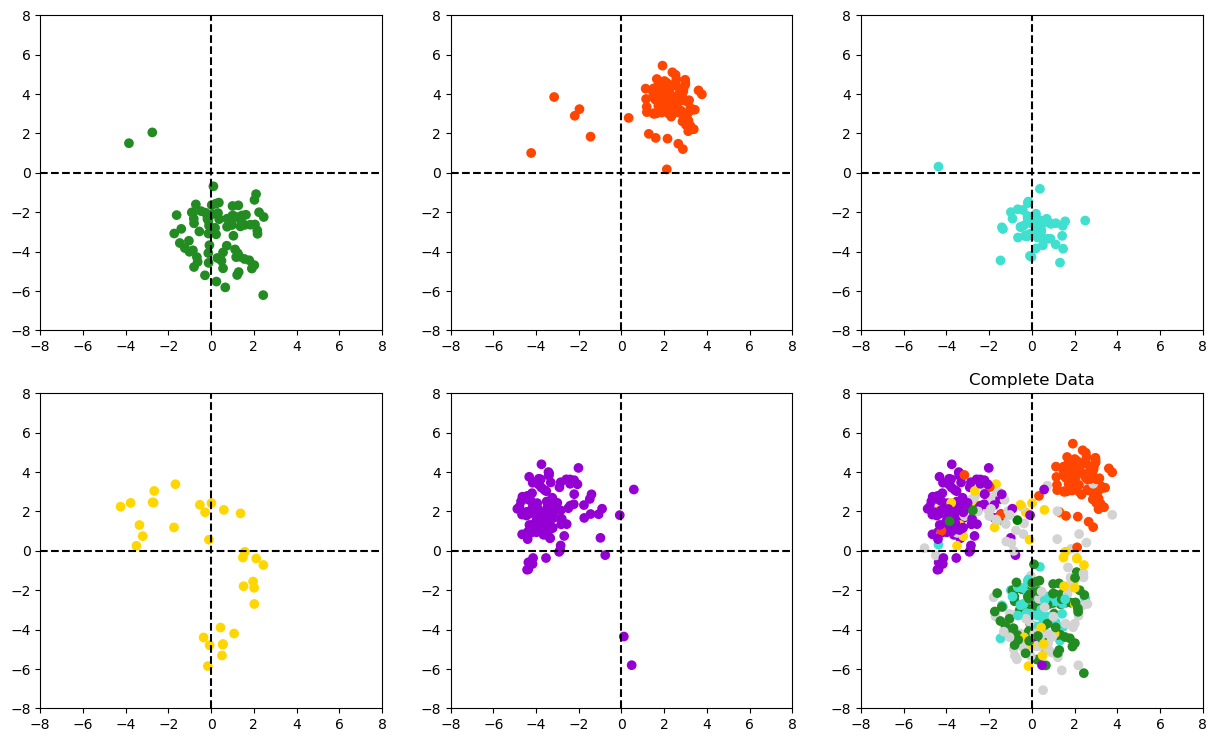

PyObject Text(0.5, 1.0, 'Complete Data')

In [84]:
PyPlot.figure()
fig, ax = PyPlot.subplots(nrows=2, ncols=3, figsize=(15, 9))
scalepar = 8
ax[1].scatter(latents[hatcols.=="forestgreen",1],latents[hatcols.=="forestgreen",2],c=hatcols[hatcols.=="forestgreen"])
ax[1].set_xlim(-scalepar,scalepar)
ax[1].set_ylim(-scalepar,scalepar)
ax[1].axhline(y = 0.0,c="black",linestyle="--")
ax[1].axvline(x = 0.0,c="black",linestyle="--")

ax[2].scatter(latents[hatcols.=="gold",1],latents[hatcols.=="gold",2],c=hatcols[hatcols.=="gold"])
ax[2].set_xlim(-scalepar,scalepar)
ax[2].set_ylim(-scalepar,scalepar)
ax[2].axhline(y = 0.0,c="black",linestyle="--")
ax[2].axvline(x = 0.0,c="black",linestyle="--")

ax[3].scatter(latents[hatcols.=="orangered",1],latents[hatcols.=="orangered",2],c=hatcols[hatcols.=="orangered"])
ax[3].set_xlim(-scalepar,scalepar)
ax[3].set_ylim(-scalepar,scalepar)
ax[3].axhline(y = 0.0,c="black",linestyle="--")
ax[3].axvline(x = 0.0,c="black",linestyle="--")

ax[4].scatter(latents[hatcols.=="darkviolet",1],latents[hatcols.=="darkviolet",2],c=hatcols[hatcols.=="darkviolet"])
ax[4].set_xlim(-scalepar,scalepar)
ax[4].set_ylim(-scalepar,scalepar)
ax[4].axhline(y = 0.0,c="black",linestyle="--")
ax[4].axvline(x = 0.0,c="black",linestyle="--")

ax[5].scatter(latents[hatcols.=="turquoise",1],latents[hatcols.=="turquoise",2],c=hatcols[hatcols.=="turquoise"])
ax[5].set_xlim(-scalepar,scalepar)
ax[5].set_ylim(-scalepar,scalepar)
ax[5].axhline(y = 0.0,c="black",linestyle="--")
ax[5].axvline(x = 0.0,c="black",linestyle="--")

ax[6].scatter(latents[:,1],latents[:,2],c=hatcols)
ax[6].set_xlim(-scalepar,scalepar)
ax[6].set_ylim(-scalepar,scalepar)
ax[6].axhline(y = 0.0,c="black",linestyle="--")
ax[6].axvline(x = 0.0,c="black",linestyle="--")
ax[6].set_title("Complete Data")